# DiCE ML Comparison with Optimal Point Method 

We compare the DiCE Model-agnostic methods with the optimal point method in this notebook. 

1. First, we import DiCE ML model-agnostic methods 
2. Second, we import the packaged files needed to run the "Optimal Point" Methodology 
3. Third, we run the experiments and compare the results at the end using different models such as SVM and random forest classifier.
4. Finally, we compare the runtimes of DiCE and the Optimal Point methodology

Note: Running experiments for the adult income can take hours. Please be mindful of the runtime for these experiments.

# Step 1: Importing DiCE ML and helper functions 

Below we import DiCE ML and their relevant helper functions. We import the sci-kit learn library and some of their necessary methods to make sure that we can run the experiments. 

In [ ]:
# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as mpatches

import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
from matplot

import json 
import datetime  

import warnings
import random
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Step 2: Import the necessary functionality to make Optimal Point methodology work 

We import many of the methods needed for the ```optimal_point()``` function to work as intended below. We import additional methods from ```binary_search_optimal_point().```

In [2]:
from files.common_functions import euclidean_distance, closest_border_point, closest_point, move_from_A_to_B_with_x1_displacement
from files.common_functions import get_multi_dim_border_points, det_constraints, real_world_constraints, constraint_bounds
from files.common_functions import balance_dataset, check_class_balance, convert_columns
from files.binary_search_optimal_point import find_decision_boundary

In [3]:
df=pd.read_csv('../../toy_dataset.csv')
# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True, random_state=1)

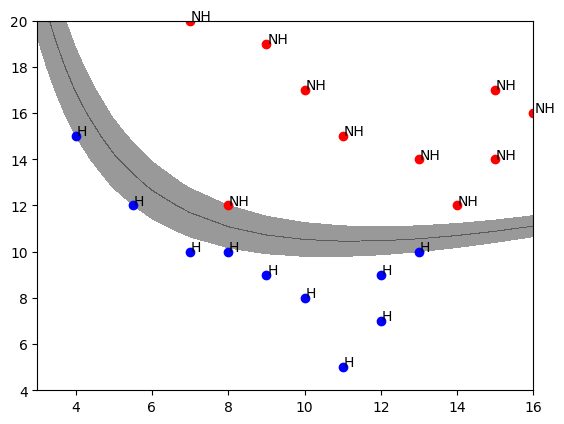

In [4]:
def visualize_dataset():
    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values
    # svm_classifier = svm.SVC(kernel='linear', C=10)
    #svm_classifier = svm.SVC(kernel='poly', C=10)
    svm_classifier = svm.SVC(kernel='poly',C=10, degree=2)
    # svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)
    svm_classifier.fit(X_train, y_train)
    color_ls = []
    for k in y_train:
        if k == 1:
            color_ls.append('b')
        else:
            color_ls.append('r')
    color_ls
    label = []
    for k in y_train:
        if k == 1:
            label.append('H')
        else:
            label.append('NH')
    label
    def plot_decision_boundary(clf, X, y):
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max),np.arange(x2_min, x2_max))
        Z = clf.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        m = np.nonzero(Z < -19)
        Q = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, colors='k', levels=[-1, 0, 1], alpha=0.4,linestyles=['--', '-', '--'])
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        
    plot_decision_boundary(svm_classifier, X_train, y_train)

    for k, (i,j) in enumerate(X_train):
        plt.scatter(i, j, c = color_ls[k])
        plt.text(i+0.02, j+0.02, label[k])

visualize_dataset()

In [9]:
def optimal_point(dataset, model, desired_class, original_class, chosen_row=-1, threshold=10000, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[], plot=False): 
    """
    Finds the closest point to the decision boundary from an undesired point,
    optionally constrained by real-world conditions.
    This essentially finds the counterfactual explanation for a given point by minimizing the distance to the given boundary.
    This method is important because it addresses a key problem with the original optimal_point() function where we generated an R^n dimensional grid that we would then have to iterate over. 
    The problem with iterating over such a grid is eventually that we will hit a memory error for high-dimensional features such as 20, 30 or 40 features. This will cause the function to crash. 
    Additionally, due to the exponential increase of the number of features to search, the grid will become infeasible to search (curse of dimensionality). 

    Parameters
    ----------
    dataset : pd.DataFrame
        Full dataset containing features and a final column with class labels.
    
    model : sklearn-like classifier
        A binary classification model with a `.fit()` and `.predict()` method.
    
    desired_class : int or label
        The target class we want the corrected point to belong to.
    
    original_class : int or label
        The actual class label of the undesired point.
    
    chosen_row :  int 
        The selected row of the dataset to find the counterfactual explanation for
    
    threshold : int, optional
        Max number of decision boundary points to sample. Default is 10000.
    
    point_epsilon : float, optional
        Precision used to estimate decision boundary points. Default is 0.1.
    
    epsilon : float, optional
        Step size used when displacing a point toward the decision boundary. Default is 0.01.
    
    constraints : list, optional
        A list of real-world constraints on the features (e.g., ranges, logic constraints). Default is [].
    
    deltas : list, optional
        Tolerances or maximum displacements for each feature. Default is [].

    Returns
    -------
    np.ndarray
        A corrected point that satisfies the class change and real-world constraints.

    Raises
    ------
    Exception
        If the number of constraints exceeds the number of features.

    Notes
    -----
    - This function trains the model on the provided dataset, generates boundary points using
      `find_decision_boundary`, applies constraints, and finds the closest optimal point.
    - Assumes binary classification and relies on external functions like `real_world_constraints`,
      `closest_point`, `move_from_A_to_B_with_x1_displacement`, etc., which must be defined elsewhere.
    - Includes plotting for visualization (e.g., boundary contours, points), which requires matplotlib.
    - The function blends boundary approximation with counterfactual generation, useful for explainable AI.
    - Print statements are for progress tracking; plotting is partially commented out but can be enabled.
    - Usage: Call with a dataset and model to generate counterfactuals, e.g., for model interpretation or optimization.

    Examples
    --------
    >>> import pandas as pd
    >>> from sklearn.linear_model import LogisticRegression
    >>> dataset = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0], 'label': [0, 1, 0]})
    >>> model = LogisticRegression()
    >>> undesired_coords = [2, 0]  # Example point from class 0
    >>> optimal = optimal_point(dataset, model, desired_class=1, original_class=0, undesired_coords=undesired_coords)
    >>> print(optimal)  # e.g., array([[1.5, 0.5]])
    """

    # Convert categorical columns if needed (before balancing)
    inv_col_map = convert_columns(dataset)

    # Extract features and labels before balancing
    X_orig = dataset.iloc[:, :-1]
    
    # Save the original row's feature values
    undesired_coords = X_orig.iloc[chosen_row, :].copy()

    # Balance the dataset
    dataset = balance_dataset(df=dataset, target=dataset.columns[-1])
    
    if not check_class_balance(dataset, target=dataset.columns[-1]):
        raise RuntimeError("Failed to balance classes for binary classification")
    
    sampled_dataset = dataset.sample(n=min(dataset.shape[0], 10000))

    # Extract new training features/labels after balancing
    X_train = sampled_dataset.iloc[:, :-1]
    y_train = sampled_dataset.iloc[:, -1]
    # Train the model
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    # -------------------------------
    # STEP 2: Find decision boundary
    # -------------------------------
    print("boundary points started generation...")

    # This step uses binary interpolation to get points close to the decision boundary
    boundary_points = find_decision_boundary(model, X_train, y_train,
                                             threshold=threshold, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)

    # -------------------------------
    # STEP 3: Apply real-world constraints (optional)
    # -------------------------------
    # Reduce boundary points based on external rules (e.g., cost limits, physics constraints)
    contours = real_world_constraints(points=boundary_points,
                                      undesired_coords=undesired_coords,
                                      constraints=constraints)
    contours_pd = np.unique(contours.to_numpy(), axis=0)  # Remove duplicates from constrained points
    undesired_datapt = np.reshape(undesired_coords, (1, -1))  # Reshape undesired point to 2D array

    # -------------------------------
    # STEP 4: Find closest point on constrained boundary
    # -------------------------------
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")  # Note: Duplicate print, possibly a typo
    if plot:
        plt.plot(contours[:,0], contours[:,1], lw=0.5, color='red')  # Commented: Plot contours for visualization

    # -------------------------------
    # STEP 5: Post-process based on class flip requirement
    # -------------------------------

    # If we want to *flip* the class of the point...
    if desired_class != original_class: 
         # Move in the direction of the boundary, slightly overshooting
        D = optimal_datapt - undesired_datapt  # Compute direction vector
        deltas = D * (1+epsilon)  # Scale by (1 + epsilon) to overshoot
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    else:
        # If we want to *stay within* the same class (more constrained)
        closest_boundedpt = None
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], deltas=deltas)  # Determine constraints

        if len_constr > X_train.shape[1]:
            raise Exception("There cannot be more constraints than features")

        elif len_constr == X_train.shape[1]:
            # All n dimensions are constrained, so generate an exact grid of boundary candidates
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0],
                                                              extents=deltas,
                                                              step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)  # Convert to NumPy array
            x_values, y_values = np_bounded_contour[:, 0], np_bounded_contour[:, 1]  # Extract x/y for plotting
            #plt.scatter(x_values, y_values, marker='o')  # Plot bounded points
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)  # Find closest on border

        else:
            # Partially constrained - less than n dimensions are constrained
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, deltas)  # Apply partial bounds
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)  # Find closest
        
        D = closest_boundedpt - undesired_datapt  # Compute direction
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)  # Move point
    
    # Plot original and optimal points with connecting line
    if plot and contours_pd is not None:
        contours = contours_pd.to_numpy()
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)
        plt.scatter(contours[:,0], contours[:,1], lw=0.5, color='purple', label="Decision Boundary Points")  # Commented: Plot contours for visualization
        plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r', label="NH: Not Healthy")  # Plot undesired point
        plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')  # Label 'NH' (e.g., Non-Healthy)
        plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'g', label="H: Healthy")  # Plot optimal point (changed to green for distinction)
        plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
        plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')  # Dashed line between points
        red_patch = mpatches.Patch(color='red', label='Not Healthy')
        blue_patch = mpatches.Patch(color='blue', label='Healthy')
        green_patch = mpatches.Patch(color='green', label="Counterfactual")
        purple_patch = mpatches.Patch(color='purple', label='Decision Boundary Point')
        plt.legend(loc='lower left', handles=[red_patch, blue_patch, purple_patch, green_patch])
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title("Toy Dataset")
        plt.show()
        
    categorical_features = [col for col in inv_col_map.keys()]
    final_optimal_datapt = [] 

    for col in X_train.columns:
        if col in categorical_features: 
            idx = optimal_datapt[0,X_train.columns.get_loc(col)].astype(int)
            final_optimal_datapt.append(inv_col_map[col][idx])
        else: 
            final_optimal_datapt.append(optimal_datapt[0,X_train.columns.get_loc(col)])

    query_instance = undesired_coords
    return dataset, model, query_instance, final_optimal_datapt, euclidean_distance(undesired_datapt, optimal_datapt)

In [6]:
def run_dice_cfs(df, model, query_instance, method, continuous_features, target, chosen_row, plot=False, total_CFs=1):
    start = datetime.datetime.now()
    x_train = df.iloc[:, :-1]
    backend = 'sklearn'

    d = dice_ml.Data(dataframe=df, continuous_features=continuous_features, outcome_name=target)
    m = dice_ml.Model(model=model, backend=backend)
    exp_dice = dice_ml.Dice(d, m, method=method)
    
    sampled_dataset = df.sample(n=min(df.shape[0], 10000))

    # Extract new training features/labels after balancing
    X_train = sampled_dataset.iloc[:, :-1]
    y_train = sampled_dataset.iloc[:, -1]
    # Train the model
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    print("QUERY INSTANCE")
    query_instance = x_train.iloc[[chosen_row]] 

    dice_cfs = exp_dice.generate_counterfactuals(pd.DataFrame(data=query_instance, columns=x_train.columns), total_CFs=total_CFs, desired_class="opposite")
    cfs_list = json.loads(dice_cfs.to_json())['cfs_list']

    query_instance = np.array(query_instance)
    dist_cfs = []
    for point in cfs_list[0]: 
        point_vec = [float(point[i]) for i in range(len(point[:-1]))]
        print(euclidean_distance(np.array(point_vec), query_instance))
        dist_cfs.append(euclidean_distance(np.array(point_vec), query_instance))

    # average_distance_cfs /= len(cfs_list[0])
    # print("AVERAGE EUCLIDEAN DISTANCE AMONG 100 CFS", average_distance_cfs)

    if plot:
        for point in cfs_list[0][:5]: 
            print(point)
            x,y = point[0], point[1] 
            print("EUCLIDEAN DISTANCE:", euclidean_distance(np.array((x,y)), query_instance))
            print(query_instance)
            plt.scatter(x,y, c = 'yellow')  # Plot optimal point (changed to green for distinction)
            plt.text(x+0.002, y+0.002, 'H')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
            plt.plot([x,query_instance[0][0]], [y, query_instance[0][1]], linestyle='--')  # Dashed line between points
    end = datetime.datetime.now()
    diff = end - start
    print(f"Elapsed time: {diff}")

    return dist_cfs, diff.total_seconds()

# Step 3: Toy Dataset Experiments

We run a few experiments using the toy dataset, and we compare the results visually using both the optimal point method and the dice model-agnostic methods. 

/mnt/c/Users/Compuworld/drexel_research_2024_2025/Docs/files/common_functions.py:425: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07438268 1.07023586]]
[[-0.24514294 -4.53761911]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 68.15it/s]

7.0
4.242640687119285
10.0
5.385164807134504
5.830951894845301
[4.0, 15.0, 1.0]
EUCLIDEAN DISTANCE: 7.0
[[11. 15.]]
[8.0, 12.0, 1.0]
EUCLIDEAN DISTANCE: 4.242640687119285
[[11. 15.]]
[11.0, 5.0, 1.0]
EUCLIDEAN DISTANCE: 10.0
[[11. 15.]]
[13.0, 10.0, 1.0]
EUCLIDEAN DISTANCE: 5.385164807134504
[[11. 15.]]
[8.0, 10.0, 1.0]
EUCLIDEAN DISTANCE: 5.830951894845301
[[11. 15.]]
Elapsed time: 0:00:00.026839


([np.float64(7.0),
  np.float64(4.242640687119285),
  np.float64(10.0),
  np.float64(5.385164807134504),
  np.float64(5.830951894845301)],
 0.026839)

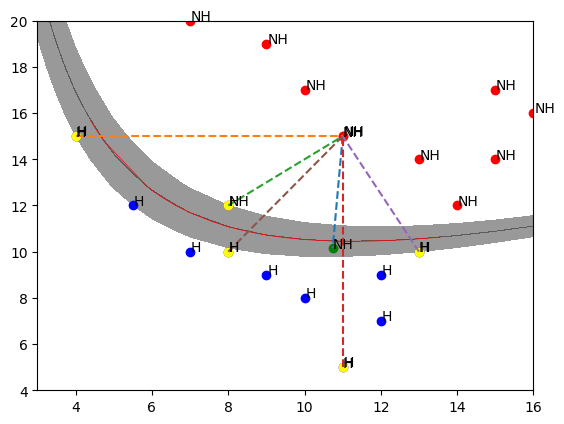

In [7]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[4:5,:]
chosen_row=4
visualize_dataset()
df, model, query_instance, opt_point, _ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=5, plot=True)

/mnt/c/Users/Compuworld/drexel_research_2024_2025/Docs/files/common_functions.py:425: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.         1.07023542]]
[[ 0.         -4.54615116]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 29.09it/s]

6.794115100585211
8.8
7.4
5.503635162326805
7.1
[6.0, 10.4, 1.0]
EUCLIDEAN DISTANCE: 6.794115100585211
[[11. 15.]]
[11.0, 6.2, 1.0]
EUCLIDEAN DISTANCE: 8.8
[[11. 15.]]
[11.0, 7.6, 1.0]
EUCLIDEAN DISTANCE: 7.4
[[11. 15.]]
[8.7, 10.0, 1.0]
EUCLIDEAN DISTANCE: 5.503635162326805
[[11. 15.]]
[11.0, 7.9, 1.0]
EUCLIDEAN DISTANCE: 7.1
[[11. 15.]]
Elapsed time: 0:00:00.045813


([np.float64(6.794115100585211),
  np.float64(8.8),
  np.float64(7.4),
  np.float64(5.503635162326805),
  np.float64(7.1)],
 0.045813)

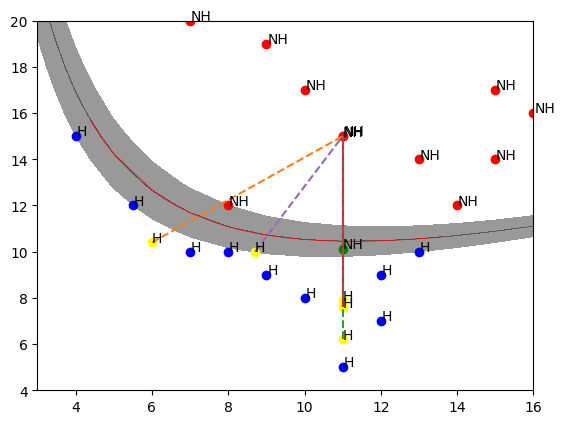

In [8]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[4:5,:]
chosen_row=4
visualize_dataset()
df, model, query_instance, opt_point,_ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=5, plot=True)

/mnt/c/Users/Compuworld/drexel_research_2024_2025/Docs/files/common_functions.py:425: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...


KeyError: 93

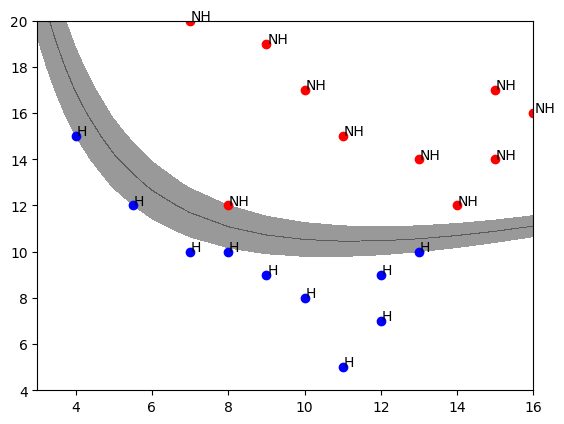

In [10]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[4:5,:]
chosen_row=4
visualize_dataset()
df, model, query_instance, opt_point,_ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=5, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06786094 1.07031697]]
[[ 0.49921989 -3.37675524]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 62.40it/s]

[13.0, 10.0, 1.0]
EUCLIDEAN DISTANCE: 4.0
[[13. 14.]]
[12.0, 9.0, 1.0]
EUCLIDEAN DISTANCE: 5.0990195135927845
[[13. 14.]]
[8.0, 12.0, 1.0]
EUCLIDEAN DISTANCE: 5.385164807134504
[[13. 14.]]
[8.0, 10.0, 1.0]
EUCLIDEAN DISTANCE: 6.4031242374328485
[[13. 14.]]
[9.0, 9.0, 1.0]
EUCLIDEAN DISTANCE: 6.4031242374328485
[[13. 14.]]
Elapsed time: 0:00:00.028538


([4.0,
  5.0990195135927845,
  5.385164807134504,
  6.4031242374328485,
  6.4031242374328485],
 0.028538)

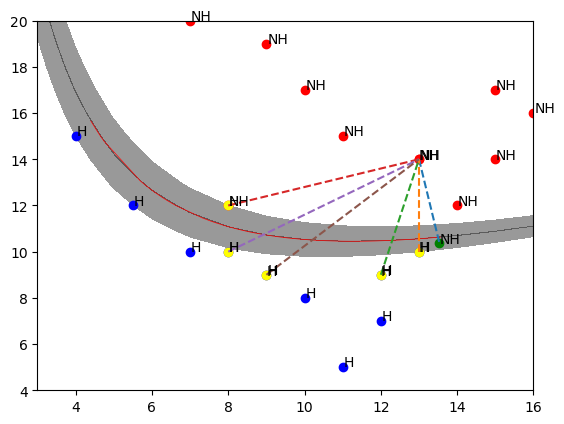

In [11]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[5:6,:]
chosen_row=5
visualize_dataset()
df, model, query_instance, opt_point,_= optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=5, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06760782 1.07031626]]
[[ 0.44629002 -3.38427496]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 25.44it/s]

[14.9, 6.2, 1.0]
EUCLIDEAN DISTANCE: 8.028075734570521
[[13. 14.]]
[13.0, 10.7, 1.0]
EUCLIDEAN DISTANCE: 3.3000000000000007
[[13. 14.]]
[9.1, 8.5, 1.0]
EUCLIDEAN DISTANCE: 6.7424031324150295
[[13. 14.]]
[10.9, 10.1, 1.0]
EUCLIDEAN DISTANCE: 4.4294469180700204
[[13. 14.]]
[13.000000000000002, 7.0, 1.0]
EUCLIDEAN DISTANCE: 7.0
[[13. 14.]]
Elapsed time: 0:00:00.050324


([8.028075734570521,
  3.3000000000000007,
  6.7424031324150295,
  4.4294469180700204,
  7.0],
 0.050324)

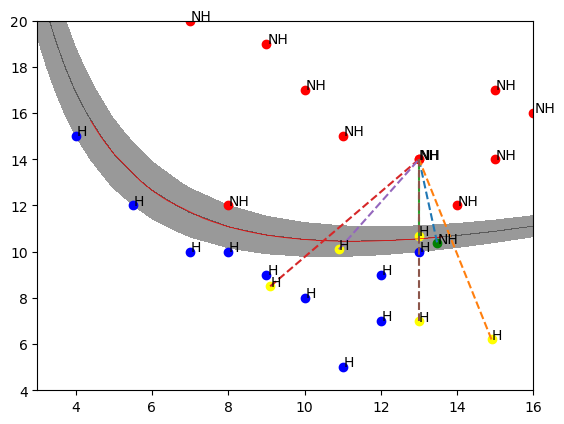

In [12]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[5:6,:]
chosen_row=5
visualize_dataset()
df, model, query_instance, opt_point, _ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=5, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06760799 1.07031627]]
[[ 0.44632244 -3.3841939 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 17.21it/s]

[13.0, 10.0, 1.0]
EUCLIDEAN DISTANCE: 4.0
[[13. 14.]]
[13.0, 8.4, 1.0]
EUCLIDEAN DISTANCE: 5.6
[[13. 14.]]
[11.4, 10.6, 1.0]
EUCLIDEAN DISTANCE: 3.7576588456111875
[[13. 14.]]
[10.7, 11.1, 1.0]
EUCLIDEAN DISTANCE: 3.7013511046643504
[[13. 14.]]
[12.0, 9.0, 1.0]
EUCLIDEAN DISTANCE: 5.0990195135927845
[[13. 14.]]
Elapsed time: 0:00:00.070137


([4.0, 5.6, 3.7576588456111875, 3.7013511046643504, 5.0990195135927845],
 0.070137)

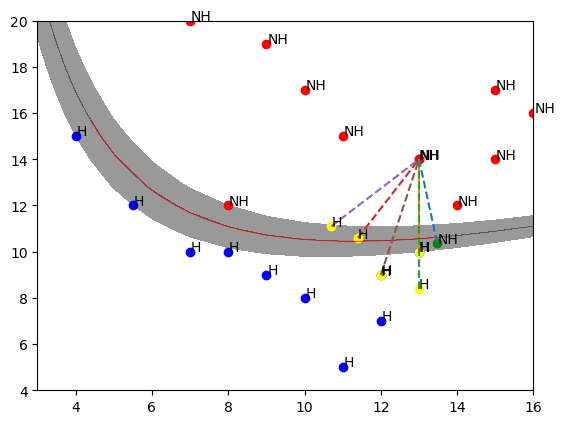

In [13]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[5:6,:]
chosen_row=5
visualize_dataset()
df, model, query_instance, opt_point, _ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=5, plot=True)

In [26]:
inv_map = { 
    1: -1, 
    -1: 1
}
x_train = df.iloc[:,:-1]
y_train  = df.iloc[:,-1]
continuous_features=['x1', 'x2']
target='y'
dice_dists, optimal_dists = [], [] 
for i in range(df.shape[0]):
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(df, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=1000, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=False)
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=100, plot=False)
    dice_dists.extend(dist_cfs)

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0704113  1.07024674]]
[[-2.60250521 -4.33750868]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 39.95it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


10.0
5.830951894845301
8.06225774829855
8.139410298049853
10.04987562112089
11.180339887498949
11.661903789690601
12.083045973594572
12.36931687685298
13.92838827718412
15.524174696260024
Elapsed time: 0:00:00.031540
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07245113 1.07155846]]
[[-0.4375329  -0.68757677]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 49.40it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


6.0
4.242640687119285
5.385164807134504
5.385164807134504
7.0710678118654755
7.280109889280518
8.06225774829855
8.602325267042627
8.94427190999916
Elapsed time: 0:00:00.026238
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07023253 1.07032069]]
[[-4.60250521 -3.33750868]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 39.77it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


10.0
6.4031242374328485
7.0710678118654755
7.826237921249264
9.055385138137417
9.219544457292887
9.848857801796104
10.44030650891055
11.045361017187261
12.36931687685298
14.142135623730951
Elapsed time: 0:00:00.030657
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0702038 1.0704812]]
[[-5.25135136 -2.22459459]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 43.45it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


9.0
5.385164807134504
6.324555320336759
6.726812023536855
7.280109889280518
7.615773105863909
7.615773105863909
8.06225774829855
8.246211251235321
10.198039027185569
12.041594578792296
Elapsed time: 0:00:00.028523
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07438227 1.07023586]]
[[-0.24516582 -4.53763819]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


7.0
4.242640687119285
10.0
5.385164807134504
5.830951894845301
6.082762530298219
6.264982043070834
6.324555320336759
6.4031242374328485
7.0710678118654755
8.06225774829855
Elapsed time: 0:00:00.029179
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06786094 1.07031697]]
[[ 0.49921989 -3.37675524]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 33.88it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.0
5.0990195135927845
5.385164807134504
6.4031242374328485
6.4031242374328485
6.708203932499369
7.0710678118654755
7.211102550927978
7.762087348130012
9.0
9.219544457292887
Elapsed time: 0:00:00.037020
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07280822 1.0707876 ]]
[[-0.38202477 -1.35955572]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 41.39it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


6.0
8.5
2.23606797749979
3.605551275463989
5.385164807134504
5.656854249492381
5.830951894845301
6.324555320336759
7.280109889280518
7.615773105863909
10.44030650891055
Elapsed time: 0:00:00.029162
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07074356 1.07031779]]
[[-1.44001627 -3.36803579]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 31.07it/s]

4.47213595499958
5.830951894845301
7.280109889280518
7.615773105863909
7.810249675906654
7.810249675906654
8.06225774829855
8.94427190999916
9.7082439194738
9.848857801796104
11.0
Elapsed time: 0:00:00.039188
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07077479 1.07016828]]
[[-1.38202477 -6.35955572]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


7.280109889280518
8.54400374531753
8.602325267042627
9.899494936611665
10.0
10.295630140987
10.44030650891055
10.63014581273465
10.735455276791944
11.180339887498949
12.649110640673518
Elapsed time: 0:00:00.029514
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07043869 1.07019936]]
[[-2.44005919 -5.36813021]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 31.16it/s]

6.708203932499369
8.06225774829855
8.94427190999916
9.848857801796104
9.899494936611665
10.0
10.0
10.816653826391969
11.236102527122116
12.0
12.083045973594572
Elapsed time: 0:00:00.039095
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06814336 1.06444933]]
[[0.5753088 0.1917696]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


7.0
5.830951894845301
6.324555320336759
6.4031242374328485
9.0
10.44030650891055
11.0
11.180339887498949
12.0
Elapsed time: 0:00:00.048028
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...


c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06853227 1.06731223]]
[[0.72801661 0.39709997]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 49.37it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


8.5
6.264982043070834
6.726812023536855
7.762087348130012
7.826237921249264
8.139410298049853
9.7082439194738
10.735455276791944
11.236102527122116
Elapsed time: 0:00:00.025494
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06831855 1.06915862]]
[[0.63535738 1.27071476]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 52.22it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


10.0
6.4031242374328485
7.211102550927978
7.615773105863909
8.94427190999916
9.219544457292887
10.63014581273465
10.816653826391969
Elapsed time: 0:00:00.025208
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06720595 1.06883986]]
[[0.38195705 0.9213047 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]

5.830951894845301
6.324555320336759
6.4031242374328485
7.280109889280518
8.06225774829855
9.055385138137417
9.899494936611665
10.0
10.04987562112089
Elapsed time: 0:00:00.027167
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0648944  1.06935912]]
[[0.20857382 1.66859055]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 47.42it/s]

10.0
5.830951894845301
6.324555320336759
6.4031242374328485
7.810249675906654
8.06225774829855
9.899494936611665
10.0
11.180339887498949
Elapsed time: 0:00:00.026153
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06474737 1.06957275]]
[[0.20270729 2.50338411]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 47.18it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


9.0
5.656854249492381
6.708203932499369
7.0710678118654755
7.810249675906654
10.0
10.295630140987
11.045361017187261
12.36931687685298
Elapsed time: 0:00:00.026196
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0622539  1.06980376]]
[[0.13713408 5.4514637 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 51.05it/s]

10.0
7.615773105863909
9.219544457292887
9.848857801796104
12.041594578792296
12.083045973594572
12.649110640673518
14.142135623730951
15.524174696260024
Elapsed time: 0:00:00.026588
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07677387 1.06969116]]
[[-0.15895987  3.46358395]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 51.20it/s]

5.385164807134504
7.0710678118654755
7.615773105863909
8.06225774829855
9.848857801796104
10.198039027185569
10.44030650891055
12.36931687685298
13.92838827718412
Elapsed time: 0:00:00.026531
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07708316 1.06926958]]
[[-0.15206242  1.46391678]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 48.50it/s]

3.605551275463989
5.0990195135927845
5.830951894845301
6.082762530298219
8.06225774829855
8.246211251235321
8.54400374531753
10.44030650891055
12.083045973594572
Elapsed time: 0:00:00.027129
Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.         1.06808804]]
[[0.        0.5586338]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]

4.0
2.23606797749979
4.47213595499958
5.385164807134504
6.708203932499369
7.280109889280518
7.615773105863909
9.848857801796104
11.661903789690601
Elapsed time: 0:00:00.026020


In [28]:
print(np.mean(optimal_dists), np.mean(dice_dists))

3.300848695502674 8.478694738221426


In [ ]:
inv_map = { 
    1: -1, 
    -1: 1
}
x_train = df.iloc[:,:-1]
y_train  = df.iloc[:,-1]
continuous_features=['x1', 'x2']
target='y'
dice_dists, optimal_dists = [], [] 
for i in range(df.shape[0]):
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(df, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=1000, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=False)
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=100, plot=False)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
inv_map = { 
    1: -1, 
    -1: 1
}
x_train = df.iloc[:,:-1]
y_train  = df.iloc[:,-1]
continuous_features=['x1', 'x2']
target='y'
dice_dists, optimal_dists = [], [] 
for i in range(df.shape[0]):
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(df, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=False)
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row, total_CFs=100, plot=False)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

# Step 3: Adult Income Dataset Experiments

We run a few experiments using the adult income dataset comparing DiCE model-agnostic methodologies and the Optimal Point method.

We follow the following steps: 

1. Import the dataset using the helpers function from DiCE 
2. Initialize the classifier which is a Random Forest Classifier in this case
3. Iterate for 50 or 100 randomly selected points using the Optimal point method 
4. After each iteration of generation with the optimal point method, we apply the run_dice_cfs method that enables us to generate counterfactuals using DiCE's specific model-agnostic approach

In [37]:
dataset = helpers.load_adult_income_dataset()

c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\utils\helpers.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data = adult_data.replace({'income': {'<=50K': 0, '>50K': 1}})


In [38]:
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [39]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = RandomForestClassifier()

In [40]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
query_instance=x_train.iloc[4:5,:]
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
sub_dataset = dataset[dataset['income'] == 0]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 50)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 income
0    19820
1    19820
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...


KeyboardInterrupt: 

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
query_instance=x_train.iloc[4:5,:]
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
sub_dataset = dataset[dataset['income'] == 0]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 50)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
query_instance=x_train.iloc[4:5,:]
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
sub_dataset = dataset[dataset['income'] == 0]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 50)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train.shape

In [ ]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
random_integers = random.sample(range(1, 26047), 50)

for i in random_integers:
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

# Step 3: Heart Disease Dataset Experiments

We run a few experiments using the heart disease dataset comparing DiCE model-agnostic methodologies and the Optimal Point method.

We follow the following steps: 

1. Import the dataset using the helpers function from DiCE 
2. Initialize the classifier which is a Random Forest Classifier in this case
3. Iterate for 50 or 100 randomly selected points using the Optimal point method 
4. After each iteration of generation with the optimal point method, we apply the run_dice_cfs method that enables us to generate counterfactuals using DiCE's specific model-agnostic approach

In [30]:
heart_disease = pd.read_csv(
'../../heart.csv'
)

In [31]:
heart_disease

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [ ]:
x_train = heart_disease.iloc[:,:-1]
y_train = heart_disease.iloc[:,-1]
continuous_features=["age", "trestbps", "thalach", "oldpeak", "chol"]
target='target'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
dice_probs, optimal_probs = [], [] 
sub_dataset = heart_disease[heart_disease['target'] == 1]

random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 100)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    df, model, query_instance, opt_point, dist = optimal_point(heart_disease, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs,_ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01034247 0.         1.00853512 1.00977844 1.00940166 0.
  1.01154255 1.01010982 1.01294256 1.00973622 1.01146914 1.00923049
  1.01294256]]
[[-2.95019531  0.          0.68847656  4.55761719  1.68701172  0.
  -0.65576172 -9.19775391 -0.34423828  3.82788086 -0.68847656  1.31152344
  -0.34423828]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.67it/s]

35.07648785155093
Elapsed time: 0:00:00.143414
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00978155 1.00760883 1.01064021 1.00949203 1.01084155 0.
  1.00760883 1.01036347 1.01101101 1.00953848 1.008803   1.00941848
  1.00825746]]
[[ 4.62255859  0.42138672 -1.57861328  1.98730469 -1.20117188  0.
   0.42138672 -2.77978516 -1.          2.18740234  0.84277344  1.73583984
   0.57861328]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 22.89it/s]

43.04648650006177
Elapsed time: 0:00:00.135851
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01045302 0.         1.0104137  1.01025882 1.00858715 0.
  1.01101101 1.01009481 0.         1.008994   1.01101101 1.00930025
  1.00860148]]
[[ -2.23046875   0.          -2.44238281  -3.90332031   0.71386719
    0.          -1.         -10.65429688   0.           1.00297852
   -1.           1.44238281   0.72119141]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]

21.400934559032695
Elapsed time: 0:00:00.138508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0101326  0.         1.00957622 1.01008176 1.00984937 1.00836748
  0.         1.00991373 0.         1.01043932 0.         0.
  1.00899101]]
[[ -7.61767578   0.           2.38232422 -12.35351562   6.70410156
    0.61767578   0.          11.70703125   0.          -2.3
    0.           0.           1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.38it/s]

29.508642801728445
Elapsed time: 0:00:00.145689
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01028934 1.00155888 1.01053713 1.00961567 1.00964318 0.
  1.00155888 1.01010758 0.         1.00968177 1.01057331 1.00942734
  0.        ]]
[[-3.49169922  0.11865234 -1.88134766  2.62695312  2.82958984  0.
   0.11865234 -9.38964844  0.          3.17285156 -1.76269531  1.76269531
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


29.404251393293453
Elapsed time: 0:00:00.210016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01285326 1.01152436 1.01037933 1.01021116 1.01074595 1.00848023
  1.00899101 1.00989549 1.00899101 0.99435908 1.00700675 1.00923954
  1.0130111 ]]
[[-0.35498047 -0.66357422 -2.66357422 -4.78417969 -1.35498047  0.66357422
   1.          9.66357422  1.          0.06357422  0.33642578  1.32714844
  -0.33642578]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '202.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.44it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


14.683664392786973
Elapsed time: 0:00:00.215426
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00987893 1.0083828  1.01050525 1.00990848 1.01122908 0.
  1.00937828 1.01006239 1.01101101 1.00969128 1.01081055 1.00946036
  1.0116224 ]]
[[  8.34130859   0.62353516  -2.          11.03515625  -0.82275391
    0.           1.62353516 -16.18847656  -1.           3.27060547
   -1.24707031   1.87060547  -0.62353516]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10000000298023223' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 19.23it/s]

27.712812921102035
Elapsed time: 0:00:00.148015
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01227818 1.01101101 1.00860337 1.0101818  1.00970216 1.01101101
  0.         1.00992486 1.01101101 1.07453513 1.00860337 1.00637775
  1.00637775]]
[[-0.44433594 -1.          0.72216797 -5.55664062  3.39013672 -1.
   0.         13.44042969 -1.         -0.01665039  0.72216797  0.27783203
   0.27783203]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '210.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.85it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


37.53984549781738
Elapsed time: 0:00:00.193019
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00990174 1.011259   1.01062911 1.00989487 1.01030613 0.
  1.011259   1.01006143 0.         1.00965083 1.01062911 1.00957821
  0.        ]]
[[ 10.27734375  -0.80322266  -1.60644531   9.60644531  -3.30029297
    0.          -0.80322266 -16.44189453   0.           2.89160156
   -1.60644531   2.39355469   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '202.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.96it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


26.756120795062948
Elapsed time: 0:00:00.189251
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00799381 0.         1.017085   1.01176198 1.01061217 0.
  1.0242701  1.01019547 0.         0.98262032 1.0242701  1.00301302
  1.017085  ]]
[[ 0.50244141  0.         -0.14355469 -0.57421875 -1.65087891  0.
  -0.07177734 -5.16796875  0.          0.03588867 -0.07177734  0.14355469
  -0.14355469]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]

30.985319104375865
Elapsed time: 0:00:00.142508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01017041 1.00868672 1.00960191 1.01005369 1.01004127 0.
  1.0113167  1.00984754 1.01101101 1.00766708 1.0113167  0.
  1.00868672]]
[[ -5.92773438   0.76806641   2.53613281 -18.81347656 -24.47558594
    0.          -0.76806641   6.62353516  -1.           0.43193359
   -0.76806641   0.           0.76806641]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 17.54it/s]

16.3
Elapsed time: 0:00:00.157044
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0098611  0.         1.01134321 1.00989901 1.01071034 1.00884896
  0.         1.01003405 1.00884896 1.00962841 1.01057651 0.
  1.00884896]]
[[  7.27050781   0.          -0.75292969  10.          -1.42285156
    0.87646484   0.         -29.66455078   0.87646484   2.71704102
   -1.75292969   0.           0.87646484]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '255.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '129.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

11.832159566199232
Elapsed time: 0:00:00.177946



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01086477 0.         1.01608462 1.00698493 1.00865774 0.
  1.022243   1.01034573 0.99804678 1.00453142 1.022243   0.99804678
  1.022243  ]]
[[-1.16894531  0.         -0.16699219  0.33398438  0.75146484  0.
  -0.08349609 -2.92236328  0.08349609  0.18369141 -0.08349609  0.08349609
  -0.08349609]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '119.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 12.58it/s]

34.53751583423452
Elapsed time: 0:00:00.180016



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0098204  1.01398588 1.01057893 1.00981311 1.01032085 0.
  1.01135642 1.01014879 1.00864721 1.00968053 0.         1.00932315
  1.00864721]]
[[ 5.62255859 -0.25439453 -1.74560547  5.40332031 -3.14892578  0.
  -0.74560547 -6.7890625   0.74560547  3.16049805  0.          1.49121094
   0.74560547]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '277.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '66.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 12.49it/s]

20.92844953645635
Elapsed time: 0:00:00.175614



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00949513 0.         0.         0.         1.01088474 0.
  1.01354829 1.01008224 0.         1.00679578 1.01354829 0.
  1.00647647]]
[[  1.99951172   0.           0.           0.          -1.14257812
    0.          -0.28564453 -12.28271484   0.           0.31420898
   -0.28564453   0.           0.28564453]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]

19.502820308868152
Elapsed time: 0:00:00.143510
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01004729 1.00899101 1.00954409 1.00983169 1.00987267 0.
  1.01101101 1.00993138 0.         1.01104072 1.00871607 1.00957166
  1.01473388]]
[[-21.35693359   1.           2.21435547   6.           7.93115234
    0.          -1.          14.71875      0.          -0.97148438
    0.78564453   2.35693359  -0.21435547]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 19.80it/s]

43.04648650006177
Elapsed time: 0:00:00.142015
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00981925 1.0134535  1.01143152 1.00986803 1.01083577 1.00857252
  1.00656996 1.01004639 1.00857252 1.00956901 1.01245095 0.
  1.00857252]]
[[  5.58691406  -0.29345703  -0.70654297   7.65234375  -1.20947266
    0.70654297   0.29345703 -21.77197266   0.70654297   2.34243164
   -0.41308594   0.           0.70654297]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '278.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '65.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.76it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

23.51510153071851
Elapsed time: 0:00:00.198017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01044199 0.         1.01891771 1.00977199 1.00956112 0.
  1.01181613 1.01004332 1.00819038 1.00954082 1.01070048 1.00909438
  1.00819038]]
[[ -2.28613281   0.          -0.11425781   4.42871094   2.30029297
    0.          -0.55712891 -23.31347656   0.55712891   2.19858398
   -1.44287109   1.11425781   0.55712891]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '201.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


22.85191458062103
Elapsed time: 0:00:00.208015
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00982987 0.         1.01113158 1.00971414 1.01068721 0.
  1.00817763 1.01007107 1.00774441 1.0115334  1.00817763 1.00967497
  1.00774441]]
[[  5.93554688   0.          -0.89355469   3.53222656  -1.47070312
    0.           0.55322266 -14.21142578   0.44677734  -0.65966797
    0.55322266   3.10644531   0.44677734]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 19.61it/s]

32.09361307176243
Elapsed time: 0:00:00.147729
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01044142 1.01127295 1.01171808 1.0103652  1.00803011 1.01101101
  1.00899101 1.00979134 1.00873025 0.         1.01127295 0.
  0.        ]]
[[-2.2890625  -0.79443359 -0.58886719 -2.76660156  0.51171875 -1.
   1.          4.83935547  0.79443359  0.         -0.79443359  0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '231.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

33.82957286162508
Elapsed time: 0:00:00.176510
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00977152 0.         1.01075383 1.00961872 1.00722742 1.01101101
  1.01150879 1.01005362 1.0084957  1.00966685 1.0107602  1.0107602
  1.0084957 ]]
[[  4.41943359   0.          -1.34082031   2.64794922   0.36328125
   -1.          -0.67041016 -18.83886719   0.67041016   3.03071289
   -1.32958984  -1.32958984   0.67041016]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.61it/s]

59.2452529743945
Elapsed time: 0:00:00.140538
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00976393 1.011259   1.01062911 1.00989487 1.00972708 1.01101101
  1.00489325 1.01009674 0.         1.00965083 1.01062911 1.01166819
  0.        ]]
[[  4.27734375  -0.80322266  -1.60644531   9.60644531   3.69970703
   -1.           0.19677734 -10.44189453   0.           2.89160156
   -1.60644531  -0.60644531   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]

30.27276003274231
Elapsed time: 0:00:00.147508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00958804 1.01123791 0.         1.00938218 1.0104123  0.
  0.         1.0100562  0.         1.00965668 1.01061857 1.00938218
  0.        ]]
[[  2.45068359  -0.81689453   0.           1.63378906  -2.45068359
    0.           0.         -17.97167969   0.           2.94082031
   -1.63378906   1.63378906   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '204.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 17.24it/s]

22.32957679849755
Elapsed time: 0:00:00.151508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00979986 1.00821536 1.00854848 1.00904062 1.01053257 1.01101101
  0.         1.0121065  1.01101101 1.00964116 1.01101101 1.00670124
  1.00899101]]
[[ 5.04541016  0.56494141  0.69482422  1.05175781 -1.89746094 -1.
   0.         -0.48046875 -1.          2.81362305 -1.          0.30517578
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.41it/s]

35.07648785155093
Elapsed time: 0:00:00.150508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01078502 1.00899101 1.01059835 1.00987162 1.00890733 0.
  1.00940235 1.01007248 0.         1.00966694 1.01073352 1.00951158
  1.0114681 ]]
[[ -1.28759766   1.          -1.68896484   7.86621094   0.92333984
    0.           1.68896484 -13.93652344   0.           3.03144531
   -1.37792969   2.06689453  -0.68896484]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '257.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.67it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


27.509271164463808
Elapsed time: 0:00:00.195911
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00992009 0.         0.98280034 1.00990967 1.00963409 0.
  1.01210008 1.01004755 1.00790862 1.0090483  1.01210008 1.00971299
  1.00790862]]
[[ 12.63867188   0.           0.03613281  11.18066406   2.75927734
    0.          -0.48193359 -21.24121094   0.48193359   1.06025391
   -0.48193359   3.51806641   0.48193359]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 11.01it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

19.652989594461197
Elapsed time: 0:00:00.187374
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01080644 0.         1.01121393 1.00694936 1.00924122 0.
  1.00827202 1.011546   1.00758086 1.00957499 1.01086622 0.
  1.00758086]]
[[-1.25341797  0.         -0.83300781  0.33007812  1.33007812  0.
   0.58349609 -0.65429688  0.41650391  2.37543945 -1.16699219  0.
   0.41650391]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '110.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 14.18it/s]

21.434551546510136
Elapsed time: 0:00:00.166508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01044142 1.01127295 1.01171808 1.0103652  1.00803011 1.01101101
  1.00899101 1.00979134 1.00873025 0.         1.01127295 0.
  0.        ]]
[[-2.2890625  -0.79443359 -0.58886719 -2.76660156  0.51171875 -1.
   1.          4.83935547  0.79443359  0.         -0.79443359  0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '231.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

34.698126750589864
Elapsed time: 0:00:00.207015
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0095757  0.         1.00239664 1.00968909 1.00929308 1.00899101
  1.0076786  1.01012865 0.         1.00964375 1.01101101 1.00883796
  1.01178787]]
[[ 2.37939453  0.          0.13183594  3.24755859  1.42773438  1.
   0.43408203 -7.85205078  0.          2.83408203 -1.          0.86816406
  -0.56591797]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '155.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

12.625767303415662
Elapsed time: 0:00:00.183015



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00976641 1.00881737 1.00964611 1.00986895 1.01180977 0.
  1.00881737 1.00993331 0.         1.00762147 1.00317441 0.
  1.00881737]]
[[ 4.32275391  0.85302734  2.85302734  7.70605469 -0.55908203  0.
   0.85302734 15.14404297  0.          0.42363281  0.14697266  0.
   0.85302734]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '253.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.81it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


17.0
Elapsed time: 0:00:00.188389
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01198329 1.01240814 1.01050525 1.00976858 1.00695385 0.
  1.01174562 1.01010122 1.00826039 1.00949005 1.01174562 1.00912945
  1.00826039]]
[[-0.51025391 -0.42041016 -2.          4.36328125  0.33056641  0.
  -0.57958984 -9.97949219  0.57958984  1.97958984 -0.57958984  1.15917969
   0.57958984]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.73it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


19.551214796017153
Elapsed time: 0:00:00.208408
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.03723404 0.         1.03723404 1.00472391 1.01533179 1.06597748
  0.         1.02799429 0.         0.99369324 1.06597748 0.9841595
  0.95960826]]
[[-0.03808594  0.         -0.03808594  0.19042969 -0.19042969 -0.01904297
   0.         -0.05712891  0.          0.0609375  -0.01904297  0.03808594
   0.01904297]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.63it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

11.313708498984761
Elapsed time: 0:00:00.193559
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00964526 1.00899101 1.00962501 1.00989412 1.01087612 0.
  1.00899101 1.00993806 0.         1.00757462 1.00347581 0.
  1.00899101]]
[[ 2.84619141  1.          2.69238281  9.53808594 -1.15380859  0.
   1.         16.30615234  0.          0.41542969  0.15380859  0.
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.41it/s]

43.04648650006177
Elapsed time: 0:00:00.142507
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01020907 1.00899101 1.00894683 1.00961858 1.00958145 0.
  1.01101101 1.00812646 1.00899101 0.98506293 1.01211295 1.01068335
  1.00789585]]
[[-4.83203125  1.          0.95800781  2.64697266  2.41210938  0.
  -1.          0.53808594  1.          0.03950195 -0.47900391 -1.47900391
   0.47900391]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

27.308606701917256
Elapsed time: 0:00:00.140508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01027503 0.         1.00080872 1.00982656 1.01248929 1.00886786
  1.01113469 1.01009624 1.01936167 1.00964568 1.01056703 0.
  1.01936167]]
[[ -3.67333984   0.           0.10888672   5.82226562  -0.40673828
    0.89111328  -0.89111328 -10.49560547  -0.10888672   2.84956055
   -1.78222656   0.          -0.10888672]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

31.811947441173732
Elapsed time: 0:00:00.142019
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00987893 1.0083828  1.01050525 1.00990848 1.01122908 0.
  1.00937828 1.01006239 1.01101101 1.00969128 1.01081055 1.00946036
  1.0116224 ]]
[[  8.34130859   0.62353516  -2.          11.03515625  -0.82275391
    0.           1.62353516 -16.18847656  -1.           3.27060547
   -1.24707031   1.87060547  -0.62353516]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  7.27it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


12.025389806571761
Elapsed time: 0:00:00.232021
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00894843 0.         1.01795716 1.01030374 1.00958465 1.0260407
  0.         1.01017355 0.         0.97937763 1.0260407  0.
  1.0260407 ]]
[[ 0.95947266  0.         -0.12792969 -3.32617188  2.43066406 -0.06396484
   0.         -5.82080078  0.          0.03198242 -0.06396484  0.
  -0.06396484]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '334.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


58.15118227516961
Elapsed time: 0:00:00.233522
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00765757 1.00899101 1.0113855  1.00890327 1.00939163 1.00899101
  1.00627333 1.01004826 1.00861829 1.01192014 1.00627333 1.00965422
  1.00861829]]
[[  0.43017578   1.          -0.72998047   0.91992188   1.65917969
    1.           0.27001953 -20.92919922   0.72998047  -0.52700195
    0.27001953   2.91992188   0.72998047]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '63.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

21.68501786948768
Elapsed time: 0:00:00.158483
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01028492 1.01139109 1.01123495 1.00974164 1.00898606 1.01101101
  1.00899101 1.00966179 0.         1.01091922 1.00941553 1.00631319
  1.00920719]]
[[-3.54589844 -0.72705078 -0.81884766  3.90820312  0.99511719 -1.
   1.          2.98535156  0.         -1.09975586  1.72705078  0.27294922
   1.27294922]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '146.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.85it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

10.707007051459339
Elapsed time: 0:00:00.194019
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00960593 1.00646443 1.01177712 0.         1.01118405 0.
  1.00646443 1.0107101  1.00646443 1.00607311 0.         1.00646443
  1.00646443]]
[[ 2.56201172  0.28466797 -0.56933594  0.         -0.85400391  0.
   0.28466797 -1.42333984  0.28466797  0.25620117  0.          0.28466797
   0.28466797]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '59.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 17.24it/s]

69.9714227381436
Elapsed time: 0:00:00.155527
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00593657 0.95960826 0.         1.00341349 1.01295517 0.
  0.95960826 1.01112973 1.06597748 0.98136973 0.         0.95960826
  0.95960826]]
[[ 0.24755859  0.01904297  0.          0.15234375 -0.34277344  0.
   0.01904297 -0.89501953 -0.01904297  0.03427734  0.          0.01904297
   0.01904297]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '243.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.299999976158142' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.35it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concaten

14.247806848775006
Elapsed time: 0:00:00.203515
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00972908 1.00899101 1.01066705 1.0106412  1.01058482 0.
  1.01196446 1.01059577 0.         1.00924647 1.00792123 0.
  1.00804315]]
[[ 3.72705078  1.         -1.51513672 -1.57617188 -1.72802734  0.
  -0.51513672 -1.69628906  0.          1.33935547  0.48486328  0.
   0.51513672]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '258.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '120.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

6.928203230275509
Elapsed time: 0:00:00.220022
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00948469 0.         1.0110322  1.01017189 1.00994845 1.01206651
  1.01206651 1.01004297 1.00794191 1.00939381 1.01206651 0.
  1.01206651]]
[[  1.95898438   0.          -0.97949219  -5.87695312  19.58984375
   -0.48974609  -0.48974609 -23.5078125    0.48974609   1.66513672
   -0.48974609   0.          -0.48974609]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 19.42it/s]

8.94427190999916
Elapsed time: 0:00:00.144530
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00987075 0.         1.01101101 1.00985643 1.01024433 1.00885533
  1.00155888 1.01003376 1.00885533 1.00964876 1.01053713 0.
  1.00885533]]
[[  7.81347656   0.          -1.           7.03369141  -4.13476562
    0.88134766   0.11865234 -29.91503906   0.88134766   2.87456055
   -1.88134766   0.           0.88134766]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]

29.103264421710495
Elapsed time: 0:00:00.145510
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00861829 0.         0.         1.00957192 1.00820452 0.
  0.99232793 1.01041847 1.02831291 1.02831291 0.         0.99232793
  0.99232793]]
[[ 0.72998047  0.          0.          2.35839844  0.56152344  0.
   0.05615234 -2.41455078 -0.05615234 -0.05615234  0.          0.05615234
   0.05615234]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '197.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 12.27it/s]

29.817612245114464
Elapsed time: 0:00:00.181023



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00989715 1.00850656 1.01050525 1.00987421 1.0098162  1.00689905
  1.01149787 1.01005185 1.00899101 1.0095705  0.         1.00844714
  1.00689905]]
[[  9.81884766   0.67529297  -2.           8.02832031   5.49414062
    0.32470703  -0.67529297 -19.47998047   1.           2.35058594
    0.           0.64941406   0.32470703]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '301.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '66.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.52it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

32.882366094914765
Elapsed time: 0:00:00.197997
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00962871 1.01230099 1.0107019  1.00980574 1.01053924 0.
  1.01230099 1.01010702 0.         1.00967044 1.01114919 1.01037698
  1.00770945]]
[[ 2.71923828 -0.43994141 -1.43994141  5.19824219 -1.87402344  0.
  -0.43994141 -9.43847656  0.          3.06367187 -0.87988281 -2.68017578
   0.43994141]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.799999976158142' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 15.27it/s]

37.589892258425
Elapsed time: 0:00:00.162285
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00972908 1.00899101 1.01066705 1.0106412  1.01058482 0.
  1.01196446 1.01059577 0.         1.00924647 1.00792123 0.
  1.00804315]]
[[ 3.72705078  1.         -1.51513672 -1.57617188 -1.72802734  0.
  -0.51513672 -1.69628906  0.          1.33935547  0.48486328  0.
   0.51513672]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '232.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 16.53it/s]

18.1463494951464
Elapsed time: 0:00:00.155508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01098642 0.         1.01061931 1.00986672 1.00948107 1.00454296
  1.00454296 1.01017048 1.01551665 1.00734282 1.00454296 1.00914774
  1.01551665]]
[[-1.02490234  0.         -1.63183594  7.57714844  1.9453125   0.18408203
   0.18408203 -5.92529297 -0.18408203  0.37910156  0.18408203  1.18408203
  -0.18408203]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.62it/s]

30.251611527321977
Elapsed time: 0:00:00.141509
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01040479 1.01231645 1.01050525 1.01047356 1.01267954 0.
  1.01179719 1.01034776 1.00820918 1.00950007 1.01179719 0.
  1.00820918]]
[[-2.49609375 -0.43701172 -2.         -2.13378906 -0.37792969  0.
  -0.56298828 -2.90527344  0.56298828  2.01928711 -0.56298828  0.
   0.56298828]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.10it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


47.22033460279586
Elapsed time: 0:00:00.220016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00718975 0.         1.01282598 1.01056393 1.0111285  1.01566781
  1.01566781 1.01029673 1.00439509 0.9915558  0.         1.00439509
  1.00439509]]
[[ 0.35839844  0.         -0.35839844 -1.79199219 -0.89599609 -0.17919922
  -0.17919922 -3.40478516  0.17919922  0.05375977  0.          0.17919922
   0.17919922]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '273.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 11.98it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with emp

47.3392015141785
Elapsed time: 0:00:00.183015
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00877753 0.         1.01122544 1.00979605 1.01040815 0.
  1.01245385 1.01016322 1.00755801 1.01129002 1.01245385 1.00877753
  1.00755801]]
[[ 0.82519531  0.         -0.82519531  4.95117188 -2.47558594  0.
  -0.41259766 -6.18896484  0.41259766 -0.78393555 -0.41259766  0.82519531
   0.41259766]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '283.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '161.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

20.11566553708825
Elapsed time: 0:00:00.249610
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01015794 0.         1.00870805 1.01020896 1.00978828 1.00870805
  0.         1.00991114 1.01101101 1.01078921 1.00870805 0.
  1.00943315]]
[[-6.39599609  0.          0.78076172 -4.83447266  4.76953125  0.78076172
   0.         11.36474609 -1.         -1.28076172  0.78076172  0.
   1.78076172]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '218.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '118.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

30.140338418803463
Elapsed time: 0:00:00.226043
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01041645 0.         1.00840524 1.00918373 1.00956808 1.00899101
  1.01275448 1.00929836 0.         1.04224342 1.00840524 1.00862837
  1.00840524]]
[[-2.42626953  0.          0.63232422  1.23632812  2.33740234  1.
  -0.36767578  1.43847656  0.         -0.03232422  0.63232422  0.73535156
   0.63232422]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]

31.061390825267306
Elapsed time: 0:00:00.147013
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00986076 1.0111895  1.00664234 1.01067422 1.00976527 0.
  1.00330693 1.01004601 1.01101101 1.00971835 1.01050525 1.0094063
  0.        ]]
[[  7.25244141  -0.85009766   0.29980469  -1.49902344   4.30175781
    0.           0.14990234 -21.95263672  -1.           3.58500977
   -2.           1.70019531   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '202.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


26.756120795062948
Elapsed time: 0:00:00.186754
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00982331 0.         1.0106692  1.00969474 1.00984676 0.
  0.         1.01056874 1.01101101 1.00958779 1.00896991 1.00934063
  1.00802446]]
[[ 5.71533203  0.         -1.51025391  3.30761719  6.58984375  0.
   0.         -1.77685547 -1.          2.44921875  0.97949219  1.53076172
   0.51025391]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '294.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.85it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


20.762706952610973
Elapsed time: 0:00:00.195018
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00992372 1.01164302 1.01119362 1.00982768 1.01024743 0.
  1.01101101 1.01005992 0.         1.0097355  1.01082084 1.01046937
  1.00836231]]
[[ 13.24023438  -0.61572266  -0.84716797   5.86035156  -4.08300781
    0.          -1.         -16.85595703   0.           3.81748047
   -1.23144531  -2.15283203   0.61572266]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

53.44380225994404
Elapsed time: 0:00:00.139017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01040871 1.00623261 1.0118943  1.01050206 1.00928104 0.
  1.00862381 1.00979976 1.00623261 1.00881966 1.00862381 1.00623261
  0.        ]]
[[-2.47216797  0.26708984 -0.53417969 -2.01269531  1.40380859  0.
   0.73291016  5.04296875  0.26708984  0.8546875   0.73291016  0.26708984
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '180.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  6.77it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


16.881943016134134
Elapsed time: 0:00:00.245129
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00964786 0.         1.01117798 1.00633279 1.00826039 0.
  0.         1.01036715 0.         1.00832192 1.01235872 1.00962777
  1.00765225]]
[[ 2.8671875   0.         -0.85839844  0.27441406  0.57958984  0.
   0.         -2.75195312  0.          0.60087891 -0.42919922  2.71240234
   0.42919922]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '156.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '64.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

14.982656640262435
Elapsed time: 0:00:00.182013
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00636502 0.         1.01127925 1.00983685 1.00940664 0.
  1.01484476 1.0102827  1.00872399 1.0095743  1.01127925 1.00872399
  1.01484476]]
[[ 0.27685547  0.         -0.79052734  6.18945312  1.70117188  0.
  -0.20947266 -3.57373047  0.79052734  2.37158203 -0.79052734  0.79052734
  -0.20947266]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 19.42it/s]

10.428806259586953
Elapsed time: 0:00:00.146510
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00982577 1.00899101 1.01050525 1.00991318 1.00982698 0.
  1.01101101 1.01002983 1.00899101 1.00965762 1.01101101 0.
  1.00019901]]
[[  5.79589844   1.          -2.          11.6328125    5.83642578
    0.          -1.         -33.85742188   1.           2.94897461
   -1.           0.           0.10205078]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


19.551214796017153
Elapsed time: 0:00:00.210017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01029462 1.00647647 1.00929356 1.01010101 1.00986675 0.
  0.         1.00995225 0.         1.01058949 1.00858811 1.01050525
  0.        ]]
[[ -3.42919922   0.28564453   1.42871094 -10.           7.57861328
    0.           0.          21.14990234   0.          -1.71435547
    0.71435547  -2.           0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '319.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '136.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with e

35.608987629529715
Elapsed time: 0:00:00.218016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00877681 0.         1.01068562 1.00975393 1.01030184 1.00899101
  1.01122616 1.01010133 1.00877681 1.00963511 1.01055382 1.01025256
  1.00899101]]
[[ 0.82470703  0.         -1.47412109  4.10351562 -3.34716797  1.
  -0.82470703 -9.96826172  0.82470703  2.76694336 -1.82470703 -4.
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 19.02it/s]

19.502820308868152
Elapsed time: 0:00:00.148148
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01029216 1.00899101 1.01221003 1.00984759 1.01035018 1.01101101
  1.0086917  1.00993934 1.00560877 1.00872939 0.         0.
  1.0086917 ]]
[[-3.45800781  1.         -0.45800781  6.62597656 -2.88525391 -1.
   0.77099609 16.64892578  0.22900391  0.79389648  0.          0.
   0.77099609]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '267.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.19it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


28.634943687739288
Elapsed time: 0:00:00.219540
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0134535  0.         1.01114855 1.01028689 0.         1.0134535
  0.         1.01006146 1.00656996 1.00885406 0.         1.00885406
  0.        ]]
[[ -0.29345703   0.          -0.88037109  -3.52148438   0.
   -0.29345703   0.         -16.43359375   0.29345703   0.88037109
    0.           0.88037109   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '294.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.48it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


20.762706952610973
Elapsed time: 0:00:00.200016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01009513 0.         1.01163781 1.01008176 1.00856758 1.01264866
  0.         1.00994601 0.         1.02020202 1.00899101 1.01101101
  0.        ]]
[[-10.61767578   0.          -0.61767578 -12.35351562   0.70410156
   -0.38232422   0.          18.70703125   0.          -0.1
    1.          -1.           0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '210.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  9.76it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


37.53984549781738
Elapsed time: 0:00:00.202016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00710722 0.         0.         1.00950373 1.01851395 0.
  1.00848468 1.01033449 0.         1.00951319 1.0115121  1.00899444
  1.00698932]]
[[ 0.34814453  0.          0.          2.03417969 -0.11962891  0.
   0.66552734 -3.02050781  0.          2.07373047 -0.66894531  1.00341797
   0.33447266]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '143.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '109.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with e

13.124404748406688
Elapsed time: 0:00:00.209014
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00933746 0.99950266 1.02072018 1.00959218 1.00823516 0.
  1.02072018 1.01081663 0.99950266 1.00706202 0.         0.99950266
  0.        ]]
[[ 1.5234375   0.09521484 -0.09521484  2.47558594  0.57128906  0.
  -0.09521484 -1.23779297  0.09521484  0.34277344  0.          0.09521484
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '232.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 16.00it/s]

18.1463494951464
Elapsed time: 0:00:00.159016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01049569 1.00899101 1.0076786  1.00986201 1.00899737 0.
  1.01178787 1.01012397 1.00821844 1.00955402 1.01116472 1.00910843
  1.00821844]]
[[-2.03857422  1.          0.43408203  7.31835938  1.00634766  0.
  -0.56591797 -8.14794922  0.56591797  2.26367188 -0.86816406  1.13183594
   0.56591797]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 17.79it/s]

31.137758429276825
Elapsed time: 0:00:00.153722
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00924702 1.01230612 1.01050525 1.00965754 1.01017939 0.
  1.01230612 1.01011194 0.         1.00962903 1.01115175 1.00923363
  1.00899101]]
[[ 1.34033203 -0.43896484 -2.          2.94824219 -5.63134766  0.
  -0.43896484 -9.0234375   0.          2.72158203 -0.87792969  1.31689453
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '235.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '151.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

13.085106037017814
Elapsed time: 0:00:00.238017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0098707  0.         1.01093514 1.00992248 1.00956018 0.
  1.0081349  1.01004237 0.         1.00957551 1.01093514 1.00970813
  1.01187201]]
[[  7.81054688   0.          -1.08105469  13.02734375   2.29541016
    0.           0.54052734 -23.83740234   0.           2.37832031
   -1.08105469   3.45947266  -0.54052734]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '303.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.33it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


21.88606862823929
Elapsed time: 0:00:00.191344
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00969719 1.00899101 1.01101101 1.00169445 1.00819512 0.
  0.         1.01011058 1.00773453 1.00931194 1.01101101 1.00886599
  1.00773453]]
[[ 3.33447266  1.         -1.          0.12060547  0.55859375  0.
   0.         -9.13427734  0.44482422  1.46689453 -1.          0.88964844
   0.44482422]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

24.81612379079376
Elapsed time: 0:00:00.140016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01306918 0.         1.01152099 1.00981106 1.00909793 1.01101101
  1.01101101 1.01008645 1.00878827 1.00961634 1.01121464 1.00799381
  1.01101101]]
[[ -0.33007812   0.          -0.66503906   5.34472656   1.11865234
   -1.          -1.         -11.68457031   0.83251953   2.63154297
   -0.83251953   0.50244141  -1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '231.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


33.82957286162508
Elapsed time: 0:00:00.176087
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00880369 0.         1.01053312 1.00993046 1.00937358 1.00893545
  1.02970882 1.01012475 1.01101101 1.0026584  0.         1.00949525
  1.02970882]]
[[ 0.84326172  0.         -1.89550781 14.52246094  1.61132812  0.94775391
  -0.05224609 -8.09716797 -1.          0.13657227  0.          2.
  -0.05224609]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '233.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 16.73it/s]

16.440498775888766
Elapsed time: 0:00:00.168618
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01009379 1.00781587 1.01187881 1.01034532 1.00981739 0.
  1.01101101 1.00997089 0.         1.01039683 1.00930937 0.
  0.        ]]
[[-10.77001953   0.46142578  -0.53857422  -2.92578125   5.52978516
    0.          -1.          34.69726562   0.          -2.54614258
    1.46142578   0.           0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

30.692018506445613
Elapsed time: 0:00:00.144508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01015857 1.01270407 1.00926573 1.01021272 1.0101576  1.00731034
  0.         1.00991214 0.         1.0088469  1.01161732 0.
  1.00838784]]
[[-6.37060547 -0.37451172  1.37451172 -4.74902344 -6.40966797  0.37451172
   0.         11.49414062  0.          0.87490234 -0.62548828  0.
   0.62548828]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '239.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.300000047683716' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concaten

14.247806848775006
Elapsed time: 0:00:00.209015
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00951502 0.         1.00928179 1.0090649  1.01125518 0.
  1.01340798 1.00964014 1.00661486 1.00926781 1.00751399 1.00661486
  1.00899101]]
[[ 2.08154297  0.          1.40527344  1.07910156 -0.80566406  0.
  -0.29736328  2.80566406  0.29736328  1.37841797  0.40527344  0.29736328
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '185.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  7.95it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


8.411896337925237
Elapsed time: 0:00:00.218224
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01041957 0.         1.01252268 1.00992258 1.01002124 0.
  1.00748985 1.01011706 1.00499216 1.00721172 0.         0.
  1.015058  ]]
[[ -2.40820312   0.          -0.40136719  13.04443359 -47.56201172
    0.           0.40136719  -8.62939453   0.20068359   0.36123047
    0.           0.          -0.20068359]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '268.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '162.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.58it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with e

17.057549648176316
Elapsed time: 0:00:00.188016
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00950073 0.         1.01056937 1.00910341 1.00880576 1.01101101
  0.         1.01008963 1.00869829 1.01440522 1.0055329  1.00869829
  1.00869829]]
[[  2.02197266   0.          -1.77490234   1.12548828   0.84472656
   -1.           0.         -11.26904297   0.77490234  -0.23027344
    0.22509766   0.77490234   0.77490234]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '258.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '120.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with e

38.121385074522145
Elapsed time: 0:00:00.292431
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00966605 0.         1.01267954 1.00973283 1.00923702 0.
  1.01537335 1.01038192 0.         1.00619658 0.         1.0073346
  1.00468323]]
[[ 3.0234375   0.         -0.37792969  3.77929688  1.32275391  0.
  -0.18896484 -2.64550781  0.          0.26455078  0.          0.37792969
   0.18896484]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5000000059604645' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 15.62it/s]

13.92838827718412
Elapsed time: 0:00:00.158538
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00943049 1.01101101 1.01174268 1.00990923 1.01017843 0.
  1.01174268 1.01008329 0.         1.00952432 1.01174268 1.00953287
  1.00826331]]
[[  1.77246094  -1.          -0.58056641  11.12548828  -5.66162109
    0.          -0.58056641 -12.12792969   0.           2.12226562
   -0.58056641   2.16113281   0.58056641]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 19.19it/s]

37.37860350521405
Elapsed time: 0:00:00.147273
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01031012 1.00899101 1.00934126 0.         1.01012641 0.
  1.00868338 1.00993985 1.00899101 1.00228029 0.         1.00784544
  0.        ]]
[[-3.2578125   1.          1.53222656  0.         -7.99072266  0.
   0.76611328 16.79003906  1.          0.12983398  0.          0.46777344
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.83it/s]

30.677190223356508
Elapsed time: 0:00:00.148506
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00986233 1.01172237 1.01046462 1.00981627 1.01011631 1.00828349
  1.00755801 1.01006697 1.00828349 1.00955892 1.0107155  1.01122544
  1.01172237]]
[[  7.33544922  -0.58740234  -2.17480469   5.49609375  -8.68505859
    0.58740234   0.41259766 -15.08349609   0.58740234   2.28881836
   -1.41259766  -0.82519531  -0.58740234]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '294.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '153.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 11.17it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with e

20.75403575211337
Elapsed time: 0:00:00.183020
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01184694 0.         1.00763885 1.01014739 1.0097371  0.
  0.         1.00991759 1.00871766 1.01168614 1.00528872 0.
  0.        ]]
[[-0.54785156  0.          0.42675781 -6.85351562  3.84082031  0.
   0.         12.25488281  0.78662109 -0.6         0.21337891  0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '255.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 16.39it/s]

25.84569596664017
Elapsed time: 0:00:00.156057
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01014475 1.00864544 1.01101101 1.01008046 1.01058731 1.00864544
  1.0113582  1.00996997 0.         1.01044056 1.00942141 1.0060604
  1.0060604 ]]
[[ -6.97851562   0.74462891  -1.         -12.55371094  -1.72070312
    0.74462891  -0.74462891  33.63476562   0.          -2.29355469
    1.74462891   0.25537109   0.25537109]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]

25.748786379167466
Elapsed time: 0:00:00.145080
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01063335 1.0128851  0.         1.01120334 1.01095061 1.00844598
  1.0128851  1.00924729 0.         1.01271971 1.00713129 1.01042977
  1.01061289]]
[[-1.59570312 -0.35107422  0.         -0.84033203 -1.06347656  0.64892578
  -0.35107422  1.34082031  0.         -0.37236328  0.35107422 -2.35107422
  -1.64892578]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '157.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 10.52it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


41.30375285612676
Elapsed time: 0:00:00.190568
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01024327 0.         1.01050525 1.00991157 1.01029978 0.
  1.01141294 1.01014154 1.01715856 1.00968437 1.01088512 1.01176348
  1.01088512]]
[[-4.15283203  0.         -2.         11.42089844 -3.37011719  0.
  -0.71582031 -7.13671875 -0.14208984  3.19892578 -1.14208984 -0.57373047
  -1.14208984]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


29.404251393293453
Elapsed time: 0:00:00.207017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01017142 0.         1.01064986 1.00981766 1.00940969 1.00818403
  0.         1.0101541  1.00818403 1.00907336 1.01182253 1.00092963
  1.00818403]]
[[-5.89306641  0.         -1.55517578  5.53808594  1.70996094  0.55517578
   0.         -6.55517578  0.55517578  1.08896484 -0.55517578  0.11035156
   0.55517578]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.83it/s]

24.808063205337092
Elapsed time: 0:00:00.144512
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00990174 1.011259   1.01062911 1.00989487 1.01030613 0.
  1.011259   1.01006143 0.         1.00965083 1.01062911 1.00957821
  0.        ]]
[[ 10.27734375  -0.80322266  -1.60644531   9.60644531  -3.30029297
    0.          -0.80322266 -16.44189453   0.           2.89160156
   -1.60644531   2.39355469   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '256.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '150.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with e

7.647875521999556
Elapsed time: 0:00:00.250484
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00977152 0.         1.01075383 1.00961872 1.00722742 1.01101101
  1.01150879 1.01005362 1.0084957  1.00966685 1.0107602  1.0107602
  1.0084957 ]]
[[  4.41943359   0.          -1.34082031   2.64794922   0.36328125
   -1.          -0.67041016 -18.83886719   0.67041016   3.03071289
   -1.32958984  -1.32958984   0.67041016]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.4999999046325683' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 19.21it/s]

42.28474902373195
Elapsed time: 0:00:00.146844
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00906953 0.         1.01089469 1.00991389 1.00983423 0.
  1.01101101 1.01008183 0.         1.00955325 1.01179097 1.00940442
  1.00821536]]
[[  1.08447266   0.          -1.12988281  11.72753906   6.09179688
    0.          -1.         -12.34423828   0.           2.25976562
   -0.56494141   1.69482422   0.56494141]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '203.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


19.551214796017153
Elapsed time: 0:00:00.212017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00994956 1.00899101 1.01327316 1.00994555 1.0108077  0.
  1.01154485 1.01003046 1.00845986 1.00967715 1.01146498 1.00922934
  1.00845986]]
[[ 20.02441406   1.          -0.30957031  18.54785156  -1.25146484
    0.          -0.65478516 -33.15576172   0.65478516   3.12739258
   -0.69042969   1.30957031   0.65478516]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.61it/s]

21.779807161680747
Elapsed time: 0:00:00.143019
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00841014 0.         1.01239421 1.00952252 1.00971907 0.
  0.         1.01028108 0.         1.00702312 0.         1.0052454
  1.0052454 ]]
[[ 0.63427734  0.         -0.42285156  2.11425781  3.59423828  0.
   0.         -3.59423828  0.          0.33828125  0.          0.21142578
   0.21142578]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]

39.28880247602362
Elapsed time: 0:00:00.162024
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01013352 1.00814494 1.00899101 1.01013664 1.00952645 1.00814494
  1.0118619  1.01051661 1.00814494 1.00785349 1.0118619  1.01050525
  1.00814494]]
[[-7.56542969  0.54345703  1.         -7.39257812  2.13183594  0.54345703
  -0.54345703 -1.95605469  0.54345703  0.46953125 -0.54345703 -2.
   0.54345703]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4901161138336505e-09' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 18.87it/s]

35.07135583350036
Elapsed time: 0:00:00.146509
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01142659 1.00851086 1.01101101 1.0106946  1.00941848 1.00851086
  1.00688035 1.01029558 1.00899101 1.00887039 1.01285721 0.
  1.00851086]]
[[-0.70898438  0.67724609 -1.         -1.45507812  1.73583984  0.67724609
   0.32275391 -3.41796875  1.          0.89311523 -0.35449219  0.
   0.67724609]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '302.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '65.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00, 11.84it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with em

30.814931445648227
Elapsed time: 0:00:00.205493
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00985293 1.00899101 1.01059974 1.00988298 1.0096865  0.
  1.01101101 1.01005143 1.00852782 1.0093303  1.0068032  1.0095088
  1.00852782]]
[[  6.86669922   1.          -1.68505859   8.62988281   3.22070312
    0.          -1.         -19.63916016   0.68505859   1.50712891
    0.31494141   2.05517578   0.68505859]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 18.69it/s]

22.538855339169288
Elapsed time: 0:00:00.146017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01206445 0.         1.01101101 1.00990506 1.0101818  0.
  1.01161732 1.01005014 1.00838784 1.00953075 1.01270407 1.00919328
  1.00838784]]
[[ -0.49023438   0.          -1.          10.63720703  -5.55664062
    0.          -0.62548828 -20.14306641   0.62548828   2.15136719
   -0.37451172   1.25097656   0.62548828]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

20.14050644844861
Elapsed time: 0:00:00.162998
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00981053 0.         1.01220062 1.00984698 1.01027386 1.0113855
  1.0113855  1.01003812 1.00861829 1.00967803 1.0118737  1.00930867
  1.00899101]]
[[  5.32958984   0.          -0.45996094   6.59960938  -3.68896484
   -0.72998047  -0.72998047 -26.49902344   0.72998047   3.1359375
   -0.54003906   1.45996094   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]

21.470910553583888
Elapsed time: 0:00:00.139508
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00973362 0.         1.0083941  1.01079011 1.01019651 0.
  1.01545842 1.00990761 1.00459995 1.00103188 1.00876068 1.00459995
  1.00876068]]
[[ 3.79052734  0.          0.62792969 -1.27929688 -5.140625    0.
  -0.18603516 10.93066406  0.18603516  0.11162109  0.81396484  0.18603516
   0.81396484]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '255.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


25.84569596664017
Elapsed time: 0:00:00.237019
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01018949 1.01151765 1.01101101 1.01030339 1.01061072 1.00698053
  1.0084869  1.00972446 1.00698053 1.02544195 1.0084869  1.0084869
  1.01151765]]
[[-5.33105469 -0.66650391 -1.         -3.33007812 -1.65478516  0.33349609
   0.66650391  3.66455078  0.33349609 -0.06640625  0.66650391  0.66650391
  -0.66650391]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]

31.61265569356678
Elapsed time: 0:00:00.140143


In [33]:
print(np.mean(optimal_dists), np.mean(dice_dists))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (200,) + inhomogeneous part.

In [ ]:
x_train = heart_disease.iloc[:,:-1]
y_train = heart_disease.iloc[:,-1]
continuous_features=["age", "trestbps", "thalach", "oldpeak", "chol"]
target='target'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
dice_probs, optimal_probs = [], [] 
sub_dataset = heart_disease[heart_disease['target'] == 1]

random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 100)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    df, model, query_instance, opt_point, dist = optimal_point(heart_disease, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-4, epsilon=0.001, constraints=[])
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [35]:
x_train = heart_disease.iloc[:,:-1]
y_train = heart_disease.iloc[:,-1]
continuous_features=["age", "trestbps", "thalach", "oldpeak", "chol"]
target='target'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
dice_probs, optimal_probs = [], [] 
sub_dataset = heart_disease[heart_disease['target'] == 1]

random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 100)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    df, model, query_instance, opt_point, dist = optimal_point(heart_disease, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs, _ = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01044142 1.01127295 1.01171808 1.0103652  1.00803011 1.01101101
  1.00899101 1.00979134 1.00873025 0.         1.01127295 0.
  0.        ]]
[[-2.2890625  -0.79443359 -0.58886719 -2.76660156  0.51171875 -1.
   1.          4.83935547  0.79443359  0.         -0.79443359  0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


154.77092750255133
Elapsed time: 0:00:00.188033
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01018949 1.01151765 1.01101101 1.01030339 1.01061072 1.00698053
  1.0084869  1.00972446 1.00698053 1.02544195 1.0084869  1.0084869
  1.01151765]]
[[-5.33105469 -0.66650391 -1.         -3.33007812 -1.65478516  0.33349609
   0.66650391  3.66455078  0.33349609 -0.06640625  0.66650391  0.66650391
  -0.66650391]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.95it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


53.651561021092384
Elapsed time: 0:00:00.196018
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00930379 0.         1.01147754 1.00988372 1.00967441 0.
  1.00899101 1.01008109 1.00705784 1.01179907 1.00846671 1.00972395
  1.00705784]]
[[  1.44970703   0.          -0.68457031   8.68457031   3.10107422
    0.           1.         -12.45654297   0.34228516  -0.56240234
    0.65771484   3.65771484   0.34228516]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


32.078653338318304
Elapsed time: 0:00:00.187260
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0083373  0.         1.01166819 1.00976214 1.00993339 0.
  1.01334191 1.01004013 0.         1.00585349 1.01334191 1.00668006
  1.01166819]]
[[  0.60644531   0.          -0.60644531   4.24511719  15.16113281
    0.          -0.30322266 -25.16748047   0.           0.24257813
   -0.30322266   0.30322266  -0.60644531]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


40.55872285957732
Elapsed time: 0:00:00.196239
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01007335 1.01187881 1.01187881 1.01007814 1.01040904 1.01101101
  0.         1.00994293 0.         1.03237356 1.00781587 1.01101101
  0.        ]]
[[-13.77001953  -0.53857422  -0.53857422 -12.92578125  -2.47021484
   -1.           0.          17.69726562   0.          -0.04614258
    0.46142578  -1.           0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


73.36402388091864
Elapsed time: 0:00:00.184520
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.         1.0132577  1.01101101 1.00971942 1.00924371 0.
  0.         1.0100363  1.00853616 1.00934364 1.0114681  0.
  1.00853616]]
[[  0.          -0.31103516  -1.           3.59863281   1.33447266
    0.           0.         -27.82617188   0.68896484   1.53779297
   -0.68896484   0.           0.68896484]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


75.10579205360928
Elapsed time: 0:00:00.187580
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00964786 0.         1.01117798 1.00633279 1.00826039 0.
  0.         1.01036715 0.         1.00832192 1.01235872 1.00962777
  1.00765225]]
[[ 2.8671875   0.         -0.85839844  0.27441406  0.57958984  0.
   0.         -2.75195312  0.          0.60087891 -0.42919922  2.71240234
   0.42919922]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


263.5273040882102
Elapsed time: 0:00:00.195086
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00993079 1.01101101 1.01351811 1.009953   1.01085159 0.
  1.01157066 1.01003837 0.         1.00975996 1.01061471 1.00947753
  1.00843421]]
[[ 14.59277344  -1.          -0.28808594  21.49023438  -1.18701172
    0.          -0.64404297 -26.32128906   0.           4.20664063
   -1.64404297   1.93212891   0.64404297]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


106.96574217944735
Elapsed time: 0:00:00.198572
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01012329 1.00820918 1.0132577  1.01011383 1.01007031 1.00820918
  1.00820918 1.00993884 0.         1.00937832 1.01101101 1.0092302
  1.00899101]]
[[ -8.19287109   0.56298828  -0.31103516  -8.87402344 -14.36572266
    0.56298828   0.56298828  16.51171875   0.           1.62363281
   -1.           1.31103516   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


93.38024416331328
Elapsed time: 0:00:00.186198
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00989853 1.00827777 1.01086332 1.0099425  1.009931   0.
  1.01172812 1.0100345  1.00827777 1.00942527 0.         1.00827777
  0.        ]]
[[  9.95263672   0.58544922  -1.17089844  17.56347656  14.63623047
    0.          -0.58544922 -29.27246094   0.58544922   1.75634766
    0.           0.58544922   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


132.51777239298886
Elapsed time: 0:00:00.183559
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00890269 1.00236858 1.01385945 1.01385945 1.00744332 0.
  0.         1.01040487 1.00236858 1.00693353 1.01774851 1.00616982
  1.00236858]]
[[ 0.91943359  0.13134766 -0.26269531 -0.26269531  0.39404297  0.
   0.         -2.49560547  0.13134766  0.32836914 -0.13134766  0.26269531
   0.13134766]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


89.70111482027411
Elapsed time: 0:00:00.178028
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00976048 0.         1.01071923 1.00928179 1.01047937 1.0085646
  1.01143949 1.01003267 1.0085646  1.01042295 1.0085646  1.00964077
  1.0085646 ]]
[[  4.21582031   0.          -1.40527344   1.40527344  -2.10791016
    0.70263672  -0.70263672 -30.91601562   0.70263672  -2.38896484
    0.70263672   2.81054688   0.70263672]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.92it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


114.96651686469416
Elapsed time: 0:00:00.191423
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01027717 1.00700675 1.01043247 1.0103003  1.01079345 0.
  1.0130111  1.00977309 0.         1.01101858 1.0130111  1.00700675
  0.        ]]
[[-3.64501953  0.33642578 -2.33642578 -3.36425781 -1.27392578  0.
  -0.33642578  4.45019531  0.         -0.99257813 -0.33642578  0.33642578
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


301.3005144369986
Elapsed time: 0:00:00.189619
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01026065 1.00899101 1.00960593 1.00977972 1.00972119 0.
  1.01142856 1.00928723 1.00881872 1.00946293 1.0108821  1.01064702
  1.0169657 ]]
[[-3.87597656  1.          2.56201172  4.58398438  3.62158203  0.
  -0.70800781  1.41601562  0.85400391  1.87958984 -1.14599609 -1.56201172
  -0.14599609]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]

32.69556544854363
Elapsed time: 0:00:00.181017



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.99247764 1.00899101 1.01052594 1.00958415 1.00970161 1.00890501
  0.99731367 1.01008504 1.00890501 1.0096337  1.01119985 0.
  1.00890501]]
[[  0.05664062   1.          -1.92138672   2.42773438   3.38378906
    0.92138672   0.07861328 -11.87744141   0.92138672   2.75629883
   -0.84277344   0.           0.92138672]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]

42.62628297189423
Elapsed time: 0:00:00.181083



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00971781 1.00899101 1.0113167  1.00956472 1.00966475 0.
  1.01437355 1.01013256 1.00868672 1.00939377 1.0113167  1.00868672
  1.00868672]]
[[ 3.578125    1.         -0.76806641  2.31933594  3.01171875  0.
  -0.23193359 -7.62011719  0.76806641  1.66503906 -0.76806641  0.76806641
   0.76806641]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


16.15580391066938
Elapsed time: 0:00:00.180690
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01183384 1.00899101 1.00899101 1.00949989 1.00959402 1.01101101
  1.00831426 1.01029457 1.01101101 1.0094797  1.01251961 1.00874489
  1.0074929 ]]
[[-0.55175781  1.          1.          2.01855469  2.48681641 -1.
   0.59814453 -3.4296875  -1.          1.94018555 -0.40185547  0.80371094
   0.40185547]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


117.91522378386941
Elapsed time: 0:00:00.178672
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01051622 0.         1.00846557 1.00977497 1.00985015 1.0069358
  1.01150659 1.0098155  1.00849789 1.01379501 0.         1.00899101
  1.01150659]]
[[-1.95751953  0.          0.65722656  4.48730469  6.73925781  0.32861328
  -0.67138672  5.47314453  0.67138672 -0.26713867  0.          1.
  -0.67138672]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]

36.87058448139926
Elapsed time: 0:00:00.180018



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01011135 1.01250133 1.00875396 1.01015597 1.00953403 0.
  1.01169972 1.00990597 1.01250133 1.01067378 1.007511   1.00830598
  1.00899101]]
[[-9.07177734 -0.40478516  0.80957031 -6.4765625   2.16650391  0.
  -0.59521484 10.73974609 -0.40478516 -1.5         0.40478516  0.59521484
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


120.05107246501382
Elapsed time: 0:00:00.190025
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01090407 1.00819669 1.01090407 1.00984948 0.         0.
  1.00819669 1.01009033 0.         1.00958959 1.01090407 1.00909754
  1.01180977]]
[[ -1.11816406   0.55908203  -1.11816406   6.70898438   0.
    0.           0.55908203 -11.18164062   0.           2.45996094
   -1.11816406   1.11816406  -0.55908203]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.78it/s]

162.41145279813244
Elapsed time: 0:00:00.176379



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00943049 1.01101101 1.01174268 1.00990923 1.01017843 0.
  1.01174268 1.01008329 0.         1.00952432 1.01174268 1.00953287
  1.00826331]]
[[  1.77246094  -1.          -0.58056641  11.12548828  -5.66162109
    0.          -0.58056641 -12.12792969   0.           2.12226562
   -0.58056641   2.16113281   0.58056641]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


21.08862252495407
Elapsed time: 0:00:00.211246
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00960884 1.01101101 1.01040727 1.009893   1.00971271 1.00790438
  1.00805785 1.01007026 1.00790438 1.00932131 1.01105108 1.01097388
  1.00790438]]
[[  2.58105469  -1.          -2.48095703   9.43847656   3.51464844
    0.48095703   0.51904297 -14.37646484   0.48095703   1.4871582
   -0.96191406  -1.03808594   0.48095703]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


16.15580391066938
Elapsed time: 0:00:00.196094
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.94545681 0.88866729 1.08400114 1.00315182 1.01105376 1.16970352
  0.         1.01282212 0.88866729 0.84515461 1.16970352 0.94545681
  0.        ]]
[[ 0.01464844  0.00732422 -0.01464844  0.14648438 -0.95947266 -0.00732422
   0.         -0.35888672  0.00732422  0.00512695 -0.00732422  0.01464844
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


140.07376628048522
Elapsed time: 0:00:00.188611
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00971665 1.00852362 1.00840892 1.00951896 1.00987232 0.
  1.00940028 1.01012772 0.         1.00968406 1.01060044 1.00950739
  1.01148071]]
[[ 3.56347656  0.68310547  0.63378906  2.09863281  7.90966797  0.
   1.68310547 -7.90869141  0.          3.19580078 -1.68310547  2.04931641
  -0.68310547]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


33.93420103671222
Elapsed time: 0:00:00.192475
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.60023772 1.01253195 1.0096117  1.0103615  1.01017456 0.
  1.00748068 1.00997029 1.01101101 1.00580811 1.01253195 0.
  1.01101101]]
[[ 1.46484375e-03 -3.99902344e-01  2.60009766e+00 -2.79492188e+00
  -5.78710938e+00  0.00000000e+00  3.99902344e-01  3.39951172e+01
  -1.00000000e+00  2.39941406e-01 -3.99902344e-01  0.00000000e+00
  -1.00000000e+00]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


75.71776541869154
Elapsed time: 0:00:00.201742
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01014407 1.01101101 1.00949525 1.01008573 1.00959711 0.
  1.0116148  1.00997183 1.01101101 1.00594772 1.00839035 1.0116148
  1.0116148 ]]
[[ -7.01171875  -1.           2.         -11.78222656   2.50585938
    0.          -0.62646484  35.85253906  -1.           0.24824219
    0.62646484  -0.62646484  -0.62646484]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


142.63253485793484
Elapsed time: 0:00:00.193293
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00990765 1.01193505 0.         1.01068882 1.00976572 0.
  1.01193505 1.01006382 0.         1.00973531 1.01066362 1.00935663
  1.00807233]]
[[ 10.93603516  -0.52294922   0.          -1.46728516   4.31005859
    0.          -0.52294922 -15.82617188   0.           3.81474609
   -1.52294922   1.56884766   0.52294922]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


153.08494374039532
Elapsed time: 0:00:00.202217
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00929332 1.00088968 1.01927769 1.00967178 1.01461764 1.01927769
  0.         1.01018029 0.         1.00390814 1.01927769 1.0054242
  0.        ]]
[[ 1.42822266  0.10986328 -0.10986328  3.07617188 -0.21972656 -0.10986328
   0.         -5.60302734  0.          0.16479492 -0.10986328  0.21972656
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


49.02203586143684
Elapsed time: 0:00:00.197420
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00936159 1.01101101 1.00805785 1.00986424 1.0080413  1.00790438
  1.01210436 1.01013694 1.00790438 1.00871853 1.01105108 1.0089511
  1.00790438]]
[[ 1.58105469 -1.          0.51904297  7.43847656  0.51464844  0.48095703
  -0.48095703 -7.37646484  0.48095703  0.7871582  -0.96191406  0.96191406
   0.48095703]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


19.502820308868152
Elapsed time: 0:00:00.178033
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0072237  0.         1.01056532 1.00985825 1.01128401 0.
  1.00526716 1.01016124 1.01477762 1.00708191 1.01477762 1.00871925
  1.01477762]]
[[ 0.36279297  0.         -1.78759766  7.12402344 -0.78759766  0.
   0.21240234 -6.26513672 -0.21240234  0.34511719 -0.21240234  0.78759766
  -0.21240234]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


49.02203586143684
Elapsed time: 0:00:00.194654
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00992009 0.         0.98280034 1.00990967 1.00963409 0.
  1.01210008 1.01004755 1.00790862 1.0090483  1.01210008 1.00971299
  1.00790862]]
[[ 12.63867188   0.           0.03613281  11.18066406   2.75927734
    0.          -0.48193359 -21.24121094   0.48193359   1.06025391
   -0.48193359   3.51806641   0.48193359]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


112.04146553843358
Elapsed time: 0:00:00.217026
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00930379 0.         1.01147754 1.00988372 1.00967441 0.
  1.00899101 1.01008109 1.00705784 1.01179907 1.00846671 1.00972395
  1.00705784]]
[[  1.44970703   0.          -0.68457031   8.68457031   3.10107422
    0.           1.         -12.45654297   0.34228516  -0.56240234
    0.65771484   3.65771484   0.34228516]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


173.00578025025638
Elapsed time: 0:00:00.187210
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0101584  1.00733116 1.01133973 1.01011642 1.00964496 0.
  1.01268302 1.00993824 1.00733116 0.97322571 1.01268302 1.00733116
  1.01073378]]
[[-6.37744141  0.37744141 -0.75488281 -8.67675781  2.84375     0.
  -0.37744141 16.35351562  0.37744141  0.02646484 -0.37744141  0.37744141
  -1.37744141]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


25.935304123915724
Elapsed time: 0:00:00.193230
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00886848 0.         0.         1.00844481 1.00914137 0.
  0.98567868 1.01032376 1.03555193 1.02261638 0.         0.
  0.        ]]
[[ 0.89160156  0.          0.          0.6484375   1.17529297  0.
   0.04052734 -3.12060547 -0.04052734 -0.08105469  0.          0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


34.453011479404815
Elapsed time: 0:00:00.196021
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00996136 1.01169693 1.01101101 1.00991462 1.01081889 0.
  0.         1.01002473 0.         1.00972683 1.01084775 1.00943562
  1.00830875]]
[[ 26.13525391  -0.59619141  -1.          11.82861328  -1.234375
    0.           0.         -40.84765625   0.           3.69638672
   -1.19238281   1.78857422   0.59619141]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


130.58231120638047
Elapsed time: 0:00:00.196497
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0099495  1.00712331 1.0085596  1.0098737  1.00986725 1.00712331
  1.01155647 1.0100509  0.         1.00965298 1.01050525 1.00948224
  1.00899101]]
[[ 19.99804688   0.35009766   0.70019531   7.99609375   7.60742188
    0.35009766  -0.64990234 -19.84521484   0.           2.90947266
   -2.           1.94970703   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


167.70807970995315
Elapsed time: 0:00:00.206691
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00908638 1.00814161 1.01065521 1.00967816 1.00876512 0.
  1.01186526 1.01009054 1.00814161 1.01535665 1.00779726 1.00934563
  1.00814161]]
[[  1.10449219   0.54248047  -1.54248047   3.13720703   0.81689453
    0.          -0.54248047 -11.15673828   0.54248047  -0.18955078
    0.45751953   1.54248047   0.54248047]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


15.100993344810135
Elapsed time: 0:00:00.189025
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00993958 0.         1.00794191 1.00986181 1.00829058 0.
  1.01101101 1.01004248 0.         1.00958779 1.01099067 1.00934063
  1.00802446]]
[[ 16.71533203   0.           0.48974609   7.30761719   0.58984375
    0.          -1.         -23.77685547   0.           2.44921875
   -1.02050781   1.53076172   0.51025391]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


24.481829996958968
Elapsed time: 0:00:00.197730
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00923926 0.         1.01497288 1.00950539 1.00958779 0.
  1.01999497 1.01021062 0.         1.00019901 1.01999497 1.00019901
  0.        ]]
[[ 1.32666016  0.         -0.20410156  2.04101562  2.44921875  0.
  -0.10205078 -4.79638672  0.          0.10205078 -0.10205078  0.10205078
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


13.964598096615598
Elapsed time: 0:00:00.186723
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01563692 0.99345851 0.         1.01281062 1.0058132  0.99345851
  0.         1.01187201 0.         0.86583496 0.         1.0058132
  0.99345851]]
[[-0.18017578  0.06005859  0.         -0.36035156  0.24023438  0.06005859
   0.         -0.54052734  0.          0.00600586  0.          0.24023438
   0.06005859]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]

37.89459064299283
Elapsed time: 0:00:00.179668



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00986076 1.0111895  1.00664234 1.01067422 1.00976527 0.
  1.00330693 1.01004601 1.01101101 1.00971835 1.01050525 1.0094063
  0.        ]]
[[  7.25244141  -0.85009766   0.29980469  -1.49902344   4.30175781
    0.           0.14990234 -21.95263672  -1.           3.58500977
   -2.           1.70019531   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


35.41186241925155
Elapsed time: 0:00:00.192191
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01014815 1.00821536 1.00821536 1.01021137 1.00918597 0.
  1.0076838  1.00996039 0.         1.00806909 1.01232687 1.0076838
  1.0095854 ]]
[[-6.81835938  0.56494141  0.56494141 -4.77929688  1.23974609  0.
   0.43505859 25.50048828  0.          0.52207031 -0.43505859  0.43505859
   2.43505859]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


154.92288404235185
Elapsed time: 0:00:00.190511
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00950013 1.00899101 1.01050525 1.00989602 1.01024381 0.
  1.00779726 1.01007109 1.00814161 1.00948482 1.01101101 1.00906995
  1.00814161]]
[[  2.01953125   1.          -2.           9.71240234  -4.14355469
    0.           0.45751953 -14.20898438   0.54248047   1.95947266
   -1.           1.08496094   0.54248047]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


138.0136587443431
Elapsed time: 0:00:00.222701
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.008609   0.99490689 1.0255581  1.00923448 1.00936198 0.
  1.0255581  1.01046452 0.99490689 1.0027561  0.         0.99490689
  1.0255581 ]]
[[ 0.72509766  0.06591797 -0.06591797  1.31835938  1.58203125  0.
  -0.06591797 -2.17529297  0.06591797  0.13842773  0.          0.06591797
  -0.06591797]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


52.3656375880214
Elapsed time: 0:00:00.184097
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.010125   1.0114871  1.00925809 1.01036062 1.01032792 0.
  1.00899101 1.0099136  1.00685186 1.00835279 1.01316789 1.00894843
  1.01316789]]
[[-8.08105469 -0.68017578  1.36035156 -2.80175781 -3.08105469  0.
   1.         11.68896484  0.31982422  0.6121582  -0.31982422  0.95947266
  -0.31982422]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


13.964598096615598
Elapsed time: 0:00:00.184532
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01011135 1.01250133 1.00875396 1.01015597 1.00953403 0.
  1.01169972 1.00990597 1.01250133 1.01067378 1.007511   1.00830598
  1.00899101]]
[[-9.07177734 -0.40478516  0.80957031 -6.4765625   2.16650391  0.
  -0.59521484 10.73974609 -0.40478516 -1.5         0.40478516  0.59521484
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


86.94360240983806
Elapsed time: 0:00:00.191797
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00973522 0.         0.         1.00993282 1.01014158 1.00885533
  1.00155888 1.01003618 1.00885533 1.00964876 1.01053713 0.
  1.00885533]]
[[  3.81347656   0.           0.          15.03369141  -7.13476562
    0.88134766   0.11865234 -27.91503906   0.88134766   2.87456055
   -1.88134766   0.           0.88134766]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.45it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


196.6991611573369
Elapsed time: 0:00:00.182405
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01014815 1.00821536 1.00821536 1.01021137 1.00918597 0.
  1.0076838  1.00996039 0.         1.00806909 1.01232687 1.0076838
  1.0095854 ]]
[[-6.81835938  0.56494141  0.56494141 -4.77929688  1.23974609  0.
   0.43505859 25.50048828  0.          0.52207031 -0.43505859  0.43505859
   2.43505859]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


12.434226956268734
Elapsed time: 0:00:00.204026
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00991999 1.01174857 1.01064021 1.00983134 1.00873723 0.
  1.01174857 1.01006401 0.         1.00971854 1.01087353 1.01044628
  1.00825746]]
[[ 12.62255859  -0.57861328  -1.57861328   5.98730469   0.79882812
    0.          -0.57861328 -15.77978516   0.           3.58740234
   -1.15722656  -2.26416016   0.57861328]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


82.35951675428893
Elapsed time: 0:00:00.220527
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00971315 1.00790012 1.01097205 1.00748375 1.01030078 1.00806149
  1.01194598 1.01028374 1.00806149 1.00954607 1.01194598 0.9853893
  1.01194598]]
[[ 3.52001953  0.47998047 -1.04003906  0.40039062 -3.35888672  0.52001953
  -0.52001953 -3.56054688  0.52001953  2.22402344 -0.52001953  0.04003906
  -0.52001953]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


131.68902763708144
Elapsed time: 0:00:00.255685
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0115334  1.01230612 1.01033678 1.00992759 1.00976886 0.
  1.00820296 1.01002804 0.         1.00962903 1.00179331 1.00923363
  1.00949525]]
[[ -0.65966797  -0.43896484  -3.          13.94824219   4.36865234
    0.           0.56103516 -36.0234375    0.           2.72158203
    0.12207031   1.31689453   2.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


17.89553016817328
Elapsed time: 0:00:00.185020
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0088023  0.         1.01054853 1.01087575 1.01133282 1.0088023
  1.01120054 1.01008924 1.0088023  1.00961795 1.01059992 1.01025256
  1.0088023 ]]
[[  0.84228516   0.          -1.84228516  -1.15429688  -0.75878906
    0.84228516  -0.84228516 -11.31884766   0.84228516   2.64262695
   -1.68457031  -4.           0.84228516]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


39.95009386722389
Elapsed time: 0:00:00.206398
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00850224 0.         0.         1.00868922 1.01065667 0.
  0.         1.01035012 0.         1.00198723 1.0206102  0.99960813
  0.99960813]]
[[ 0.67333984  0.          0.          0.76953125 -1.5390625   0.
   0.         -2.88574219  0.          0.12504883 -0.09619141  0.09619141
   0.09619141]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


27.521627858831316
Elapsed time: 0:00:00.186017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00984907 1.01199093 1.01099448 1.00990066 1.00983704 0.
  0.         1.0100601  0.         1.00967962 1.01099448 1.0093381
  1.00801689]]
[[  6.69091797  -0.50830078  -1.01660156  10.16601562   6.19677734
    0.           0.         -16.80712891   0.           3.15146484
   -1.01660156   1.52490234   0.50830078]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


239.94001333666714
Elapsed time: 0:00:00.187412
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00970109 1.00899101 1.0108978  1.00976894 1.01016565 0.
  1.01179719 1.01004875 1.00820918 1.00965623 1.01070334 0.
  1.00820918]]
[[  3.37792969   1.          -1.12597656   4.37011719  -6.09814453
    0.          -0.56298828 -20.72021484   0.56298828   2.93701172
   -1.43701172   0.           0.56298828]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


77.62248385616117
Elapsed time: 0:00:00.198331
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00982787 1.00899101 1.01059974 1.00984768 1.01129771 0.
  1.01101101 1.01008678 1.00852782 1.0092279  1.0068032  1.0095088
  1.00852782]]
[[  5.86669922   1.          -1.68505859   6.62988281  -0.77929688
    0.          -1.         -11.63916016   0.68505859   1.30712891
    0.31494141   2.05517578   0.68505859]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


23.430749027719962
Elapsed time: 0:00:00.197230
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01003992 1.0042709  1.00914137 1.00904062 1.00988868 0.
  1.01579484 1.00990732 0.         1.01069237 1.0042709  1.00808305
  0.        ]]
[[-25.29882812   0.17529297   1.17529297   1.05175781   9.07177734
    0.          -0.17529297  10.89648438   0.          -1.45976563
    0.17529297   0.52587891   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.95it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


217.0690212812505
Elapsed time: 0:00:00.192040
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0099093  1.01101101 1.0105565  1.00987623 1.00968631 0.
  1.01101101 1.01006015 0.         1.00968398 1.01061931 1.00938144
  0.        ]]
[[ 11.13427734  -1.          -1.81591797   8.15917969   3.21875
    0.          -1.         -16.79101562   0.           3.19501953
   -1.63183594   1.63183594   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


132.5479535866171
Elapsed time: 0:00:00.186202
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00875546 0.         1.01093514 1.00901784 1.01037358 1.01101101
  1.0081349  1.01005092 0.         1.00957551 1.01093514 1.00930844
  1.01187201]]
[[  0.81054688   0.          -1.08105469   1.02734375  -2.70458984
   -1.           0.54052734 -19.83740234   0.           2.37832031
   -1.08105469   1.45947266  -0.54052734]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


103.87944936319215
Elapsed time: 0:00:00.194017
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00988039 0.         1.01361653 1.01418761 1.01068721 0.
  1.00842467 1.01019861 0.         1.00975228 1.01050525 1.00947434
  1.01158026]]
[[ 8.44287109  0.         -0.28027344 -0.2421875  -1.47070312  0.
   0.64013672 -5.08642578  0.          4.07612305 -2.          1.92041016
  -0.64013672]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


126.51493982925496
Elapsed time: 0:00:00.187020
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01142659 1.00851086 1.01101101 1.0106946  1.00941848 1.00851086
  1.00688035 1.01029558 1.00899101 1.00887039 1.01285721 0.
  1.00851086]]
[[-0.70898438  0.67724609 -1.         -1.45507812  1.73583984  0.67724609
   0.32275391 -3.41796875  1.          0.89311523 -0.35449219  0.
   0.67724609]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


186.53924520057436
Elapsed time: 0:00:00.194563
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00920749 0.         1.01638514 1.0093659  1.0091547  0.
  0.         1.01017628 1.02285153 1.07770359 0.         0.
  0.        ]]
[[ 1.2734375   0.         -0.15917969  1.59179688  1.19384766  0.
   0.         -5.73046875 -0.07958984 -0.01591797  0.          0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


126.66096478394597
Elapsed time: 0:00:00.188573
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01198329 1.01240814 1.01050525 1.00976858 1.00695385 0.
  1.01174562 1.01010122 1.00826039 1.00949005 1.01174562 1.00912945
  1.00826039]]
[[-0.51025391 -0.42041016 -2.          4.36328125  0.33056641  0.
  -0.57958984 -9.97949219  0.57958984  1.97958984 -0.57958984  1.15917969
   0.57958984]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


233.12831230890856
Elapsed time: 0:00:00.192516
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00977204 0.         1.01058949 1.00929332 1.00945724 1.01101101
  0.         1.01008727 1.00858811 1.01253257 1.00647647 1.00858811
  1.00858811]]
[[  4.4296875    0.          -1.71435547   1.42822266   1.85986328
   -1.           0.         -11.57470703   0.71435547  -0.39980469
    0.28564453   0.71435547   0.71435547]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


49.130845708169936
Elapsed time: 0:00:00.189021
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00990671 1.01216153 1.01050525 0.         1.01097251 0.
  1.01190301 1.0100474  1.00810413 1.00960713 1.01190301 1.0102913
  0.        ]]
[[ 10.82519531  -0.46826172  -2.           0.          -1.03955078
    0.          -0.53173828 -21.30908203   0.53173828   2.56982422
   -0.53173828  -3.46826172   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.89it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


42.96510211788167
Elapsed time: 0:00:00.197661
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.009787   0.         1.01090407 1.01090407 1.01050304 0.
  1.01180977 1.01004333 1.01229588 1.00957459 1.01070143 1.00939818
  1.00819669]]
[[  4.74072266   0.          -1.11816406  -1.11816406  -2.00878906
    0.          -0.55908203 -23.30859375  -0.44091797   2.37319336
   -1.44091797   1.67724609   0.55908203]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


301.62914315430464
Elapsed time: 0:00:00.186018
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00724954 0.         0.         1.0042709  1.00964551 0.
  1.01101101 1.01009045 1.0132373  1.0096326  0.         1.00926547
  1.0132373 ]]
[[  0.36621094   0.           0.           0.17529297   2.84814453
    0.          -1.         -11.16748047  -0.31298828   2.74804688
    0.           1.37402344  -0.31298828]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


13.280060240827224
Elapsed time: 0:00:00.185370
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00758369 0.         1.01161732 1.00758369 1.00517891 0.
  0.         1.01040385 0.         1.0128576  1.00517891 1.00517891
  0.        ]]
[[ 0.41699219  0.         -0.62548828  0.41699219  0.20849609  0.
   0.         -2.50195312  0.         -0.35444336  0.20849609  0.20849609
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


17.362027531368565
Elapsed time: 0:00:00.181018
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00563656 1.00899101 1.01050525 1.01047313 1.00974186 0.
  0.         1.01317762 1.00786104 1.0093476  1.00809365 0.
  1.00786104]]
[[ 0.23046875  1.         -2.         -2.13574219  3.91162109  0.
   0.         -0.31884766  0.47119141  1.54711914  0.52880859  0.
   0.47119141]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.90it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


41.49698784249286
Elapsed time: 0:00:00.194527
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01021068 1.00580471 1.01044303 1.01042145 1.00973807 0.
  1.01133025 1.01011267 1.00580471 1.00928536 1.01133025 1.00933618
  1.00899101]]
[[-4.79492188  0.23974609 -2.28076172 -2.39746094  3.85498047  0.
  -0.76025391 -8.96533203  0.23974609  1.41230469 -0.76025391  1.52050781
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


45.994456187675496
Elapsed time: 0:00:00.189026
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00943283 0.9929119  1.00946413 1.01086986 1.00988243 1.00892883
  0.9929119  1.01133886 0.9929119  1.01357157 1.00885848 1.00892883
  1.02768657]]
[[ 1.77978516  0.05810547  1.88378906 -1.16210938  8.58984375  0.94189453
   0.05810547 -0.75537109  0.05810547 -0.28378906  0.88378906  0.94189453
  -0.05810547]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


44.27233899400392
Elapsed time: 0:00:00.195571
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00813826 1.00225428 1.00942028 1.01039043 1.00920014 1.00884122
  0.         1.01060079 0.         1.01253133 1.00899101 1.00884122
  1.00225428]]
[[ 0.54150391  0.12939453  1.74121094 -2.58789062  1.26171875  0.87060547
   0.         -1.68212891  0.         -0.4         1.          0.87060547
   0.12939453]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


35.67015559259589
Elapsed time: 0:00:00.203532
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01067444 1.00899101 1.00717825 1.00988603 1.01022398 0.
  1.01157305 1.01014716 1.00843184 1.00964671 0.         1.00921531
  1.00843184]]
[[-1.49853516  1.          0.35693359  8.86132812 -4.51025391  0.
  -0.64306641 -6.86425781  0.64306641  2.8578125   0.          1.28613281
   0.64306641]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


188.8986236053614
Elapsed time: 0:00:00.215021
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00989826 1.01101101 1.01101101 1.00989587 1.00990075 0.
  1.00334997 1.01006055 0.         1.00967091 1.01144856 1.00940562
  0.        ]]
[[  9.92626953  -1.          -1.           9.69824219  10.17529297
    0.           0.15087891 -16.68066406   0.           3.06806641
   -0.69824219   1.69824219   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


26.019415827416264
Elapsed time: 0:00:00.195455
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01089508 0.         1.01101101 1.01025324 1.01041603 1.00811106
  1.00783869 1.0098369  1.00811106 1.00899101 1.00783869 0.
  1.0121706 ]]
[[-1.12939453  0.         -1.         -3.98925781 -2.42871094  0.53369141
   0.46630859  6.19140625  0.53369141  1.          0.46630859  0.
  -0.46630859]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


18.30327839486686
Elapsed time: 0:00:00.198803
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0114425  1.00506386 1.00506386 1.01015766 1.01099305 0.
  0.         1.00992071 1.00873336 1.01168614 1.00506386 0.
  0.        ]]
[[-0.70117188  0.20361328  0.20361328 -6.40722656 -1.01806641  0.
   0.         12.73730469  0.79638672 -0.6         0.20361328  0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


128.29033478793326
Elapsed time: 0:00:00.212018
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01300236 1.01151542 1.01101101 0.9608067  1.0249942  0.
  1.01302431 1.01061235 0.         1.00931015 1.01152099 1.00898854
  1.01304658]]
[[-0.33740234 -0.66748047 -1.          0.01953125 -0.06835938  0.
  -0.33496094 -1.65039062  0.          1.46308594 -0.66503906  0.99755859
  -0.33251953]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


39.03959528478747
Elapsed time: 0:00:00.186620
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00976564 0.         1.01101101 1.00981087 1.00982977 0.
  0.         1.01018704 1.00756377 1.00958636 1.01101101 1.00918661
  1.00756377]]
[[ 4.30859375  0.         -1.          5.33935547  5.93212891  0.
   0.         -5.40087891  0.41357422  2.44072266 -1.          1.24072266
   0.41357422]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


23.542514733987108
Elapsed time: 0:00:00.182020
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00965101 1.00825746 1.01174857 1.0095638  1.01087353 1.00825746
  0.         1.01004594 0.         1.00948686 1.01174857 0.
  1.00825746]]
[[  2.89306641   0.57861328  -0.57861328   2.31445312  -1.15722656
    0.57861328   0.         -21.98730469   0.           1.96728516
   -0.57861328   0.           0.57861328]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


35.41186241925155
Elapsed time: 0:00:00.184968
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01193144 0.         1.01167495 1.00951467 1.01025876 0.
  1.00745589 1.0101344  1.00833059 1.00958213 0.         1.0091646
  0.        ]]
[[-0.52392578  0.         -0.60400391  2.08007812 -3.90429688  0.
   0.39599609 -7.51611328  0.60400391  2.41601562  0.          1.20800781
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.90it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


25.58593363549589
Elapsed time: 0:00:00.195580
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00986553 0.         0.         1.00988308 1.00988039 0.
  1.00731034 1.01003589 1.00838784 1.0096579  1.01270407 1.00919328
  1.00838784]]
[[  7.50976562   0.           0.           8.63720703   8.44335938
    0.           0.37451172 -28.14306641   0.62548828   2.95136719
   -0.37451172   1.25097656   0.62548828]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


12.434226956268734
Elapsed time: 0:00:00.190020
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00986553 0.         0.         1.00988308 1.00988039 0.
  1.00731034 1.01003589 1.00838784 1.0096579  1.01270407 1.00919328
  1.00838784]]
[[  7.50976562   0.           0.           8.63720703   8.44335938
    0.           0.37451172 -28.14306641   0.62548828   2.95136719
   -0.37451172   1.25097656   0.62548828]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


253.28525420955717
Elapsed time: 0:00:00.196027
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01128961 0.         1.01071923 1.00991145 1.00987204 1.01340798
  1.01143949 1.01002664 1.0085646  1.00676319 1.0085646  1.00964077
  1.01340798]]
[[ -0.78417969   0.          -1.40527344  11.40527344   7.89208984
   -0.29736328  -0.70263672 -37.91601562   0.70263672   0.31103516
    0.70263672   2.81054688  -0.29736328]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


24.481829996958968
Elapsed time: 0:00:00.212520
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01135287 1.01401684 1.01204405 1.00983004 1.00583008 1.00865074
  1.01135287 1.01005338 1.00865074 1.00555498 1.01101101 1.00966235
  1.00865074]]
[[ -0.74755859  -0.25244141  -0.49511719   5.94140625   0.24121094
    0.74755859  -0.74755859 -18.921875     0.74755859   0.2262207
   -1.           2.99023438   0.74755859]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


26.598684177981436
Elapsed time: 0:00:00.190015
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01009021 1.01112359 1.00943914 1.01017412 1.01023503 0.
  1.00899101 1.00996929 1.01101101 1.00000966 1.01101101 0.
  1.01101101]]
[[-11.19726562  -0.89990234   1.79980469  -5.80175781  -4.29833984
    0.           1.          32.89208984  -1.           0.10009766
   -1.           0.          -1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


57.844619455918284
Elapsed time: 0:00:00.219014
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.98349733 0.         1.01210222 1.00985873 1.00982632 1.01101101
  1.01136538 1.01009775 1.00863831 1.00963162 1.01101101 1.00870319
  1.01136538]]
[[  0.03710938   0.          -0.48144531   7.1484375    5.81445312
   -1.          -0.74072266 -10.33349609   0.74072266   2.74072266
   -1.           0.77783203  -0.74072266]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


155.0463156608373
Elapsed time: 0:00:00.192867
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00952678 0.         1.01210865 1.00970186 1.00417408 0.
  1.01586051 1.01020816 1.00877969 1.0095929  1.01101101 1.00877969
  1.01292178]]
[[ 2.13330078  0.         -0.47998047  3.38671875  0.17236328  0.
  -0.17333984 -4.85302734  0.82666016  2.47998047 -1.          0.82666016
  -0.34667969]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


82.10724693959725
Elapsed time: 0:00:00.202782
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00941602 1.00899101 0.         1.01547286 1.00875621 0.
  1.00876659 1.01019126 1.00448476 1.00926977 1.01557614 1.00815487
  1.00448476]]
[[ 1.72851562  1.          0.         -0.18554688  0.81103516  0.
   0.81787109 -5.28173828  0.18212891  1.38212891 -0.18212891  0.54638672
   0.18212891]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


112.28089775202191
Elapsed time: 0:00:00.259998
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00990266 1.01129689 1.01064803 1.00987049 1.00967518 0.
  1.01101101 1.01005859 0.         1.0096891  1.0105678  1.0093528
  0.        ]]
[[ 10.37548828  -0.77978516  -1.55957031   7.79785156   3.10839844
    0.          -1.         -17.23828125   0.           3.24765625
   -1.77978516   1.55957031   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


13.280060240827224
Elapsed time: 0:00:00.229027
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.02050246 0.         1.01119915 1.01903456 1.00904768 1.00899101
  1.01119915 1.01035535 1.00880369 1.00944356 1.01059922 1.01101101
  1.00899101]]
[[-0.09716797  0.         -0.84326172 -0.11279297  1.05957031  1.
  -0.84326172 -2.84326172  0.84326172  1.81411133 -1.68652344 -1.
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


89.1852005660132
Elapsed time: 0:00:00.219381
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01017142 0.         1.01064986 1.00981766 1.00940969 1.00818403
  0.         1.0101541  1.00818403 1.00907336 1.01182253 1.00092963
  1.00818403]]
[[-5.89306641  0.         -1.55517578  5.53808594  1.70996094  0.55517578
   0.         -6.55517578  0.55517578  1.08896484 -0.55517578  0.11035156
   0.55517578]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


204.03705545807117
Elapsed time: 0:00:00.229132
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01026088 1.00899101 1.00884381 1.01010549 1.00908638 0.
  0.98677118 1.009961   1.00894629 1.00621745 0.         0.
  0.        ]]
[[-3.87255859  1.          0.87255859 -9.57519531  1.10449219  0.
   0.04248047 25.89892578  0.95751953  0.26601563  0.          0.
   0.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


10.440785411069418
Elapsed time: 0:00:00.200902
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00965844 0.         1.01093009 1.00984306 1.00969648 0.
  1.01101101 1.01012559 1.00814494 1.00967292 1.01221713 1.00907162
  1.00814494]]
[[ 2.95605469  0.         -1.08691406  6.43457031  3.32666016  0.
  -1.         -8.04296875  0.54345703  3.08691406 -0.45654297  1.08691406
   0.54345703]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


20.97617696340303
Elapsed time: 0:00:00.217019
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[  1.01085547   1.00899101   1.01033678 -42.08333333   1.01046296
    1.01101101   0.           1.01563692   1.00815157   1.01179501
    1.01185522   1.00815157   1.00815157]]
[[-1.18164062e+00  1.00000000e+00 -3.00000000e+00 -9.76562500e-04
  -2.18261719e+00 -1.00000000e+00  0.00000000e+00 -1.80175781e-01
   5.45410156e-01 -5.63671875e-01 -5.45410156e-01  5.45410156e-01
   5.45410156e-01]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


28.210104572652686
Elapsed time: 0:00:00.218365
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00868838 0.         1.01036826 1.01039415 1.00945438 0.
  1.01135999 1.01012082 0.         1.00902368 1.01135999 1.00949525
  1.00864366]]
[[ 0.76904297  0.         -2.74365234 -2.56347656  1.85009766  0.
  -0.74365234 -8.36035156  0.          1.03349609 -0.74365234  2.
   0.74365234]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


240.28227150582705
Elapsed time: 0:00:00.201028
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01027249 1.00899101 1.00940647 1.00943361 1.01020885 0.
  1.0085606  1.00993965 1.0085606  1.01174151 1.0085606  1.00899101
  1.00899101]]
[[-3.70751953  1.          1.70068359  1.78222656 -4.83691406  0.
   0.70068359 16.73486328  0.70068359 -0.58095703  0.70068359  1.
   1.        ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


30.677190223356508
Elapsed time: 0:00:00.207542
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0098707  0.         1.01093514 1.00992248 1.00956018 0.
  1.0081349  1.01004237 0.         1.00957551 1.01093514 1.00970813
  1.01187201]]
[[  7.81054688   0.          -1.08105469  13.02734375   2.29541016
    0.           0.54052734 -23.83740234   0.           2.37832031
   -1.08105469   3.45947266  -0.54052734]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


54.63378075879429
Elapsed time: 0:00:00.225024
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00978155 1.00760883 1.01064021 1.00949203 1.01084155 0.
  1.00760883 1.01036347 1.01101101 1.00953848 1.008803   1.00941848
  1.00825746]]
[[ 4.62255859  0.42138672 -1.57861328  1.98730469 -1.20117188  0.
   0.42138672 -2.77978516 -1.          2.18740234  0.84277344  1.73583984
   0.57861328]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


124.6385173210914
Elapsed time: 0:00:00.203396
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00988549 1.00850656 1.01050525 1.00983249 1.00932448 1.00689905
  1.01149787 1.01008799 1.00899101 1.00953058 0.         1.00844714
  1.00689905]]
[[  8.81884766   0.67529297  -2.           6.02832031   1.49414062
    0.32470703  -0.67529297 -11.47998047   1.           2.15058594
    0.           0.64941406   0.32470703]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


156.6748224827461
Elapsed time: 0:00:00.231194
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00976048 0.         1.01071923 1.00928179 1.01047937 1.0085646
  1.01143949 1.01003267 1.0085646  1.01042295 1.0085646  1.00964077
  1.0085646 ]]
[[  4.21582031   0.          -1.40527344   1.40527344  -2.10791016
    0.70263672  -0.70263672 -30.91601562   0.70263672  -2.38896484
    0.70263672   2.81054688   0.70263672]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

91.995054214887
Elapsed time: 0:00:00.201646


In [36]:
print(np.mean(optimal_dists), np.mean(dice_dists))

17.241132755108364 88.19524700853043


# Step 4: Runtime Tests 

The function ```runtime_tests()``` are used for comparing DiCE's model-agnostic approaches and Optimal Point for time complexity. We use a logistic regression classifier for examining runtime.

In [41]:
def runtime_tests(number_of_features, method, total_random=100):
    X, y = make_classification(n_samples=5000, n_features=number_of_features, n_informative=number_of_features,
                            n_redundant=0, n_classes=2, random_state=42)
    y = np.reshape(y, (-1, 1))
    columns = ["x"+str(i) for i in range(1, X.shape[1]+1)] 
    columns.append('y')
    dataset = pd.DataFrame(data=np.hstack((X,y)), columns=columns)
    continuous_features=["x"+str(i) for i in range(1, X.shape[1]+1)]
    target='y'
    inv_map = { 
        0: 1, 
        1: 0
    }
    dice_dists, optimal_dists = [], []
    dice_runtime = [] 
    sub_dataset = dataset[dataset[target] == 0]
    random_integers = random.sample(range(1, sub_dataset.shape[0]), total_random)
    clf = LogisticRegression()

    for i in random_integers:
        real_idx = sub_dataset.index[i]
        chosen_row=real_idx
        query_instance=X[chosen_row:chosen_row+1,:]
        label = y[chosen_row:chosen_row+1]
        df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
        optimal_dists.append(dist)
        dist_cfs, total_seconds = run_dice_cfs(df=df, model=model,query_instance=query_instance,method=method, continuous_features=continuous_features, target=target, chosen_row=chosen_row)
        dice_dists.extend(dist_cfs)
        dice_runtime.append(total_seconds)

    print(np.mean(dice_runtime))

In [42]:
runtime_tests(number_of_features=10, method='kdtree')

c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00837738 1.1228188  1.00864496 1.01203508 1.00792078 1.00597774
  1.00407381 1.01062049 1.00870027 1.00747774]]
[[ 0.62145082 -0.00995241  0.7443628  -0.49729513  0.48475953  0.25010258
   0.16942996 -1.62874628  0.77608425  0.39943399]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 22.45it/s]

3.872020725056421
Elapsed time: 0:00:00.058633
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00907049 1.01736196 1.00846955 1.0069693  1.00863159 1.00556748
  1.00876432 1.01067806 1.00775748 1.00355693]]
[[ 1.08559077 -0.13819168  0.65893654  0.33225608  0.73708245  0.22686148
   0.81636633 -1.49053768  0.44938665  0.15575745]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.71318119864328' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5.122132443376464
Elapsed time: 0:00:06.294409
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01106961 1.01087534 1.01363481 1.00626618 1.00934594 1.01056991
  1.00718624 1.00911151 1.00950065 1.00701383]]
[[-0.94526646 -1.15483183 -0.27886858  0.26950051  1.54319407 -1.77319723
   0.35795035  1.1357601   2.02161167  0.3372259 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.381962288753891' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5013450990186462' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.34s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataF

2.2841943347282605
Elapsed time: 0:00:13.363806
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01269149 1.01081423 1.05040308 1.01768688 1.01063273 1.00866115
  1.00905546 1.0086436  1.00940493 1.00496523]]
[[-0.37625682 -1.24143775 -0.02599809 -0.13239275 -1.59726533  0.75337665
   1.06830706  0.74361733  1.69627632  0.1996049 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.37952331767807007' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.3541013194488527' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depre

3.518060648532229
Elapsed time: 0:00:27.728886
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00765785 1.01204239 1.01060322 1.00742449 1.01217672 1.00877349
  1.00752205 1.01629866 1.05678473 0.99942145]]
[[ 0.43022722 -0.49551779 -1.67534009  0.39115502 -0.46500146  0.82247486
   0.40659467 -0.16135162 -0.02258824  0.09447618]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.519389023317566' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.40s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.173948560362168
Elapsed time: 0:00:06.412434
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0105691  1.00161469 1.01025409 1.01199448 1.0092932  1.00911281
  1.00678713 1.00604222 1.00948165 1.00950591]]
[[-1.77574425  0.11944874 -3.97592459 -0.50739641  1.4279742   1.13743042
   0.313361    0.25419356  1.94749322  2.04316022]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

3.9911508216407685
Elapsed time: 0:00:00.063549
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[ 1.01484048  1.01159453 -0.20967125  1.00836672  1.00905665  1.01354449
   1.00565655  1.00898644  1.02739962  1.0220203 ]]
[[-2.09656898e-01 -6.34414968e-01 -1.71908001e-04  6.17387893e-01
   1.06965243e+00 -2.85949359e-01  2.31534232e-01  9.95485559e-01
  -5.90472341e-02 -8.50245292e-02]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4148267911506653' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9422186117036438' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

3.491908660979236
Elapsed time: 0:00:27.537178
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01087678 1.01550648 1.01081034 1.00842272 1.0036624  1.00865574
  1.00659887 1.00934867 1.00858902 0.99889497]]
[[-1.15293908 -0.1844203  -1.24739573  0.63934278  0.15836628  0.75034531
   0.2959603   1.54967468  0.71481695  0.08994981]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1831587745117187' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.288519849313965' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.20s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataF

3.205350678515081
Elapsed time: 0:00:13.216643
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01118404 1.01111758 1.01061551 1.0084596  1.00922034 1.0065868
  1.00942742 1.00930938 1.0084484  1.00685368]]
[[-0.85400866 -0.90473983 -1.64191077  0.65467501  1.29444031  0.29490979
   1.76296086  1.46145698  0.6499396   0.32000954]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.4977092752919923' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5.367066911033136
Elapsed time: 0:00:06.504383
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01095735 1.01096888 1.01045566 1.01062226 1.00834961 1.01099992
  1.0088483  1.00797487 1.00416788 1.00729978]]
[[-1.05599318 -1.04343751 -2.21754289 -1.62411831  0.61097814 -1.0110813
   0.87596152  0.4977342   0.17217887  0.37304337]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.27980495558509827' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.26611091627349853' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depr

3.9543867768930223
Elapsed time: 0:00:28.053824
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01067463 1.01515375 1.01407986 1.01110006 1.00869067 1.01105088
  1.0156708  1.01254726 1.01104881 1.00851191]]
[[-1.49810667 -0.19697382 -0.24855723 -0.91913371  0.77038399 -0.96210353
  -0.17910544 -0.3975046  -0.96399642  0.67772126]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 22.35it/s]

6.186926686382954
Elapsed time: 0:00:00.062043
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00893906 1.01277057 1.01082313 1.00622189 1.00965599 1.01632987
  1.0078179  1.00907656 1.00922326 1.01164335]]
[[ 0.95099025 -0.36554636 -1.22801785  0.26632944  2.93498676 -0.16056101
   0.46185698  1.09273561  1.2993024  -0.61559886]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0714106659753417' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5.7672953485197676
Elapsed time: 0:00:06.265339
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0274961  1.0129005  1.0335869  0.96346761 1.00564957 0.99621963
  1.00538814 0.97380093 1.00656963 1.01969418]]
[[-0.05872715 -0.34921619 -0.04382038  0.02070531  0.23116073  0.07229268
   0.2180006   0.02690127  0.29342888 -0.10518626]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.3577002094818114' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10452058266265488' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.28s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Da

5.108000333040353
Elapsed time: 0:00:13.301267
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.99998605 0.97803134 1.0119516  1.01830775 1.00843215 1.0076338
  1.00137343 1.01614275 1.00502523 1.01374309]]
[[ 0.0998593   0.03059344 -0.51852467 -0.12257317  0.64319629  0.42584526
   0.1160801  -0.16542156  0.20202438 -0.27083029]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.284235964284668' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.4465887536539306' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.27s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

5.842312530253482
Elapsed time: 0:00:13.284903
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01077563 1.00762664 1.01105984 1.00394165 1.00909181 0.99965269
  1.01236813 1.00728961 1.00829275 1.01202843]]
[[-1.30316366  0.42455772 -0.95397116  0.16571205  1.11109778  0.09660989
  -0.42749744  0.37164     0.59059358 -0.49892198]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5084962148802185' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.54s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.155575799249597
Elapsed time: 0:00:06.553941
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01087327 1.01083238 1.01041245 1.01286652 1.00488799 1.00723113
  0.97130097 1.00834346 1.00748414 1.01237668]]
[[-1.15757632 -1.21438495 -2.44977599 -0.3533432   0.19657391  0.36376912
   0.02509884  0.60870466  0.40045379 -0.42596271]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9439211083816529' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.7661995897756348' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

3.4329677845570084
Elapsed time: 0:00:20.634642
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.015207   1.00895501 1.01121283 1.01220046 1.00897678 1.01179485
  1.0055063  1.00943616 1.00902055 1.00902805]]
[[-0.19496953  0.96551408 -0.83376381 -0.45999478  0.98608066 -0.5637197
   0.22375935  1.79029944  1.03019489  1.03815098]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.1953893999917602' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.5630016426904296' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:12<00:00, 12.94s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

2.9780086921392863
Elapsed time: 0:00:12.954788
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0091128  1.00887004 1.0122278  0.909058   1.00873191 0.96521359
  1.00906682 1.01125045 1.00568261 1.01235604]]
[[ 1.13741707  0.89283777 -0.45436185  0.00900575  0.79547345  0.02155148
   1.08131694 -0.8087106   0.23293761 -0.42968543]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]

6.307981897682839
Elapsed time: 0:00:00.065506
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00793141 1.00798527 1.00177044 1.00473965 1.00927983 1.01281168
  1.00671952 1.01183811 1.00742047 1.05733765]]
[[ 0.48725625  0.50030752  0.12172828  0.1910024   1.40145582 -0.36021543
   0.30688151 -0.55047689  0.39054389 -0.02233608]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5798980007634887' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


3.0812665281111284
Elapsed time: 0:00:06.503544
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.02031506 1.00490933 1.01052716 1.01404344 1.0083042  1.01893564
  1.00647723 1.02406925 1.03259667 0.99450501]]
[[-0.09891512  0.19740215 -1.91693684 -0.25078749  0.59458743 -0.11403054
   0.28570601 -0.07278779 -0.04569685  0.06418236]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.22236966086792' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.4531922148300171' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depreca

2.677620324514576
Elapsed time: 0:00:36.206551
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01101756 1.0305259  0.99855649 1.02701225 1.00668273 1.02124825
  1.00879694 1.00876227 1.00868598 1.01507656]]
[[-0.99357366 -0.05020613  0.08725964 -0.06036898  0.30346725 -0.09079171
   0.83852921  0.81501083  0.76763112 -0.19995375]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.2495442436767579' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4093706597818603' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

4.734715270461397
Elapsed time: 0:00:20.521871
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01053815 1.01055104 1.01054164 1.01199657 1.01850472 1.0291712
  1.01438548 1.00774104 1.00865088 1.00883108]]
[[-1.87781328 -1.83390214 -1.86570624 -0.50686695 -0.11975756 -0.05368319
  -0.23130548  0.44610868  0.74763588  0.86304484]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0763641495840455' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.451653013692627' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.47s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataF

2.8117257949206667
Elapsed time: 0:00:13.483960
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01088389 1.01051055 1.01059662 1.00909585 1.00425811 1.03608871
  1.0113293  1.00850954 1.01070399 1.0093874 ]]
[[-1.14368025 -1.97926458 -1.6938793   1.11607189  0.17490027 -0.03971407
  -0.76079866  0.67664353 -1.43567895  1.64771836]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.646189569426941' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.1555805306298828' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.33s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

4.366574151113491
Elapsed time: 0:00:13.346632
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01059528 1.0109556  1.01068132 1.01122609 1.01087264 1.00905521
  1.00373599 1.00915658 1.002119   1.00703182]]
[[-1.69768635 -1.05792244 -1.48341758 -0.82475512 -1.15840634  1.06802474
   0.16023863  1.19651145  0.12715633  0.33927564]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.637096880866455' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.990805487496948' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecat

2.6391522135646976
Elapsed time: 0:00:35.440237
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01066706 1.0108549  1.01034783 1.01061508 1.0087458  1.01150124
  1.01617862 1.0086525  1.00863521 1.01997179]]
[[-1.51510788 -1.18242849 -2.90473151 -1.6430716   0.80429127 -0.67377875
  -0.16446681  0.74853556  0.73903976 -0.10228576]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 19.05it/s]

4.741806309315988
Elapsed time: 0:00:00.070507
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.02784756 1.03625013 1.02796266 0.97948771 1.05494983 0.94786624
  1.03814395 0.99151839 1.02897314 0.92882918]]
[[-0.05759038 -0.039476   -0.05722775  0.03210142 -0.0234695   0.01525525
  -0.03688693  0.05364892 -0.05423314  0.0114429 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]

5.9134439028810135
Elapsed time: 0:00:00.061510
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01041129 1.00872538 1.01028704 1.01514818 1.0117695  1.00873065
  1.01060037 1.00964147 1.01160341 1.06736011]]
[[-2.4566819   0.79139561 -3.51961424 -0.19718579 -0.57178283  0.79468045
  -1.6832871   2.81605681 -0.63090888 -0.01860805]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.1067871947424317' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.951474895014038' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.40s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Data

5.011396614611598
Elapsed time: 0:00:13.411809
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01068955 0.96628906 1.01103888 1.00595992 1.00089746 1.01544386
  1.00468616 1.00845233 1.00921656 1.00924365]]
[[-1.46571347  0.02210634 -0.97320235  0.24899488  0.10995801 -0.18653004
   0.18906963  0.65159445  1.28818618  1.3343584 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.8800509075982665' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.57418211803266
Elapsed time: 0:00:06.301141
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00219296 1.01181259 1.01328594 1.01230776 1.00929274 1.01318866
  1.00791609 1.0116899  1.00700219 1.01468868]]
[[ 0.12837035 -0.55821344 -0.30837046 -0.43865453  1.42704236 -0.31774721
   0.48366688 -0.5986697   0.33591286 -0.21641239]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.9249920745031739' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9005639563070068' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.73s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

2.9183628032715796
Elapsed time: 0:00:13.747948
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00428325 1.01238675 1.01166499 1.00546053 1.00368651 1.00366977
  1.0078806  1.00717695 1.00708371 1.01380089]]
[[ 0.17567373 -0.42416888 -0.60761011  0.22149308  0.15897493  0.15855199
   0.47554938  0.35676957  0.34533093 -0.26672721]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

6.558476485147905
Elapsed time: 0:00:00.061508
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00704978 1.01092982 1.01150752 1.01150192 1.00181565 1.00443176
  1.00893337 0.99729945 1.00897848 1.01136324]]
[[ 0.34134757 -1.0872362  -0.67097324 -0.67347442  0.12240624  0.18038575
   0.94590656  0.07852409  0.98772106 -0.74188235]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]

3.838865923322277
Elapsed time: 0:00:00.061957
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01138513 1.00868941 1.01104942 1.01165463 1.00778053 1.01337442
  1.01283369 1.00636486 1.00793962 1.00933261]]
[[-0.73017553  0.76964535 -0.96343321 -0.6114082   0.45406321 -0.30031072
  -0.35742516  0.2768434   0.48920166  1.51236025]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1996748347418213' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.55s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.834798190314949
Elapsed time: 0:00:06.561416
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00869341 1.00260945 1.00842125 1.00883363 1.01075083 1.01581299
  1.01612323 1.00954657 1.00875065 1.01264721]]
[[ 0.77200537  0.13566101  0.63874505  0.86493143 -1.34617995 -0.17474876
  -0.16594556  2.2264901   0.80741924 -0.38253352]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 19.51it/s]

5.1925262517927635
Elapsed time: 0:00:00.068491
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01164489 1.01279063 1.01346068 1.00790632 1.0073136  1.02127909
  1.00701371 1.00854439 1.00891794 1.00938789]]
[[-0.61502284 -0.36292529 -0.29285042  0.48140338  0.37496802 -0.09054621
   0.33721253  0.6928676   0.93240121  1.64902982]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5745241541998292' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.45s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


3.316606519861632
Elapsed time: 0:00:06.461627
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01040408 1.01078289 1.01121914 1.01193425 1.00807528 1.0106572
  1.00712585 1.00889801 1.00869996 1.00930369]]
[[-2.50052213 -1.2910859  -0.8294514  -0.52316715  0.52375077 -1.53783393
   0.35040847  0.91552408  0.77589705  1.4495002 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.62it/s]

4.208742946041283
Elapsed time: 0:00:00.065507
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.99950117 1.00774228 1.0095011  1.00710369 1.01212847 1.0085703
  1.01363774 1.01185331 0.99160292 1.01148462]]
[[ 0.09520121  0.44635423  2.02344117  0.34772004 -0.47551845  0.70544233
  -0.27864462 -0.54597145  0.05390003 -0.68131018]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.2006516556604' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.58s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.056983083797073
Elapsed time: 0:00:06.593750
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00399046 1.00242606 1.01138189 1.00900358 1.02144222 1.00515759
  1.00752169 1.01108628 1.00769016 1.01201262]]
[[ 0.16706601  0.13235199 -0.73188527  1.01262467 -0.08926962  0.20757387
   0.40653536 -0.93077624  0.43625994 -0.50283374]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2195547829137574' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.66s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2.8000319814875003
Elapsed time: 0:00:06.676808
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01079164 1.01091412 1.01031364 1.00624727 1.00939052 1.00886715
  1.01428018 1.00949314 1.00823567 1.00967137]]
[[-1.27683375 -1.10588491 -3.22124949  0.26813708  1.65614786  0.89056007
  -0.23697136  1.99166329  0.57145678  3.07234374]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 20.25it/s]

4.846886743764125
Elapsed time: 0:00:00.066234
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01227059 1.00867099 1.01042108 1.01417582 1.0092369  1.0083117
  1.00858865 1.01295302 1.0089874  1.00883092]]
[[-0.44581815  0.75896644 -2.39961946 -0.24286884  1.3225503   0.59723598
   0.71462499 -0.34302301  0.99642883  0.86292992]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2514926295144653' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.62s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


6.918334846689883
Elapsed time: 0:00:06.636040
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00751994 1.0082197  1.00962207 1.03367571 1.0067327  1.01572891
  1.01205388 0.99564054 1.01332403 1.01309816]]
[[ 0.40624886  0.56632064  2.67148116 -0.04365976  0.308124   -0.1772989
  -0.49275262  0.06933693 -0.30484792 -0.32699966]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5088836954666137' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.71s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


3.527234834405687
Elapsed time: 0:00:06.724967
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01269305 1.01099121 1.01066529 1.01173913 1.00855094 1.0137404
  1.00677715 1.01430054 1.00631724 1.01472841]]
[[-0.37603933 -1.01995347 -1.51912396 -0.58175098  0.69600306 -0.27102492
   0.31238712 -0.23585402  0.27325119 -0.21460228]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.0979226635528563' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.3837423334584962' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depre

2.53491613283954
Elapsed time: 0:00:27.985651
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00472576 1.01167417 1.01045732 1.00904407 1.01079682 1.01260158
  1.00930699 1.01045513 1.01056871 0.9965155 ]]
[[ 0.19049694 -0.60428437 -2.20951195  1.05556149 -1.26854332 -0.38922487
   1.45641742 -2.2201309  -1.77694132  0.07390079]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.375174333585968' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1733192013336182' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.53s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Data

4.134564561450692
Elapsed time: 0:00:13.544273
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01041294 1.01039173 1.01072472 1.01538758 1.01215624 1.00832182
  1.01070841 1.00906037 1.01535388 1.00962434]]
[[-2.44688544 -2.57932734 -1.39463819 -0.18846836 -0.46940786  0.60084211
  -1.42672021  1.07389543 -0.18964821  2.68762827]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.548347096307373' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.52s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.790406186455004
Elapsed time: 0:00:06.532901
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01497914 1.00784517 1.00928533 1.00915048 1.02542905 1.01442282
  1.01089715 1.01211862 1.0122255  1.01068779]]
[[-0.20384632  0.46771541  1.41224734  1.1879025  -0.06646091 -0.22936119
  -1.12679121 -0.47772473 -0.45483034 -1.46947187]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.906562666757202' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.688856602715088' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecat

3.8873855605574064
Elapsed time: 0:00:20.751344
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07996622 1.01347354 1.01083562 1.01140123 1.00936075 1.00656793
  0.97060224 1.00873809 1.00662985 1.01318664]]
[[-0.01543554 -0.29176993 -1.20968873 -0.72179713  1.57898089  0.29328312
   0.02463598  0.79937232  0.29868949 -0.31794849]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.0854659272598266' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.1083648012710572' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.22s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Da

3.2300497339243117
Elapsed time: 0:00:13.235419
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01418231 1.01257811 1.01054479 1.01188084 1.00935967 1.01105203
  1.01318405 1.0092184  1.00859448 1.01523969]]
[[-0.24249358 -0.39276052 -1.85493885 -0.53799272  1.57630967 -0.96104732
  -0.31820563  1.29121351  0.71759558 -0.19375961]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

4.296435050857073
Elapsed time: 0:00:00.065510
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01063837 1.01065205 1.01042869 1.01180366 1.0113843  1.01318679
  1.0120653  1.00096286 1.00806444 1.00971241]]
[[-1.58315504 -1.54995389 -2.35702177 -0.56097277 -0.73061118 -0.31793377
  -0.49003214  0.11076098  0.52081279  3.51099581]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.0768299002783204' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


3.0752421025577306
Elapsed time: 0:00:06.238186
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0110255  1.01098525 1.01024422 1.0110849  1.01136484 1.00760482
  1.01127048 1.00933943 1.02486784 1.00957455]]
[[-0.98588074 -1.02611784 -4.13657928 -0.93195785 -0.74101437  0.42068045
  -0.79597812  1.52798871 -0.06893184  2.37296362]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.3333751155303957' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.45s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


3.1014682124913766
Elapsed time: 0:00:06.469322
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01060769 1.01062322 1.01028485 1.01130318 1.00927778 1.00822225
  1.01143646 1.00946211 1.00950183 1.0080153 ]]
[[-1.66302938 -1.62160369 -3.54669808 -0.77602992  1.39746114  0.56713343
  -0.70411542  1.87671189  2.02642488  0.5078943 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.4034321318135987' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.2766072942184448' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depre

2.3571524482702637
Elapsed time: 0:00:27.322859
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01047189 1.01160582 1.01115438 1.00797528 1.00833314 1.00610327
  1.01146791 1.01073739 0.98975297 1.01678166]]
[[-2.14134302 -0.6299613  -0.8759266   0.49783373  0.60492828  0.25819161
  -0.68905406 -1.37070108  0.04888387 -0.14993101]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.3165494607521057' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.8823457966314088' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:12<00:00, 12.96s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Da

4.461846207426398
Elapsed time: 0:00:12.976824
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01118259 1.01447151 1.01432984 1.019391   1.0089455  1.00749455
  1.02837788 1.00873614 1.0092717  1.01156558]]
[[-0.85505626 -0.22687431 -0.23426477 -0.10854981  0.9567992   0.40212091
  -0.05595736  0.79813677  1.3857827  -0.64612804]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.248244871629944' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


9.241914905930761
Elapsed time: 0:00:06.180407
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01540858 1.01211994 1.01104449 1.01422241 1.00582736 1.00942927
  1.010828   1.00934511 1.01195924 1.01102868]]
[[-0.18774027 -0.47742936 -0.96798344 -0.2401997   0.2410531   1.76865737
  -1.2208131   1.54124897 -0.51650557 -0.98283725]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3092914829717408' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.7113542469540395
Elapsed time: 0:00:06.381392
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01058557 1.01060977 1.01072214 1.01310806 1.00808258 1.00814725
  1.01051457 0.99532553 1.00489611 1.00868929]]
[[-1.72582113 -1.65737277 -1.39961603 -0.32596128  0.52574811  0.54413659
  -1.96381795  0.06782701  0.19688818  0.76957543]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.41486787696020505' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.2579355339868163' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depr

4.296735761026818
Elapsed time: 0:00:26.563456
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0090253  1.00285002 0.99700541 1.00815772 1.00762672 1.01127599
  1.01207412 1.0087463  1.00699833 1.01356484]]
[[ 1.03521124  0.14025916  0.07672467  0.54723314  0.4245711  -0.79254535
  -0.48795264  0.80461748  0.33547986 -0.28432299]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.626990030275116' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2.7847506623869998
Elapsed time: 0:00:06.175310
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01182742 1.00758951 1.03157013 1.01110152 1.00700377 1.0060534
  1.01096016 1.00947431 1.02964909 1.01992799]]
[[-0.55369217  0.4180027  -0.04782401 -0.91791376  0.33609     0.25491632
  -1.0529106   1.92029733 -0.05240188 -0.1027326 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

4.349026329619377
Elapsed time: 0:00:00.061257
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00920229 1.00597233 1.00866236 1.00267146 1.01264336 1.01280067
  1.01372522 1.00881417 1.01088119 1.01092665]]
[[ 1.26512128  0.24976528  0.75406218  0.13681742 -0.38308903 -0.36162759
  -0.27212517  0.85072577 -1.14717895 -1.09094427]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.011190029209649562' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.243473281397095' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depre

1.6265553527015504
Elapsed time: 0:00:34.402111
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01130124 1.01050027 1.01055622 1.01055746 1.00493446 1.01120779
  1.01131543 1.00920221 1.00948161 1.00857798]]
[[-0.77718399 -2.01990274 -1.81681412 -1.81278678  0.19838645 -0.83723729
  -0.7688119   1.26500057  1.94734088  0.70925554]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.329235075904297' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.063866366876831' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.16s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataF

4.2836961351749405
Elapsed time: 0:00:13.169006
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0108722  1.01166514 1.01058089 1.01422122 1.00910406 1.00634822
  1.01095149 1.01521163 1.00771614 1.00894154]]
[[-1.15898565 -0.60755713 -1.73969718 -0.24026756  1.1263135   0.27557769
  -1.06249592 -0.19479743  0.44123335  0.95321422]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25397446851594546' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.741869275906478
Elapsed time: 0:00:06.455950
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01061826 1.01190079 1.01052896 1.01151009 1.00867288 1.00667212
  1.00809731 1.0084726  1.00935384 1.00933678]]
[[-1.63460815 -0.53235822 -1.91040955 -0.66983387  0.76004758  0.30249613
   0.5298283   0.6602535   1.5620817   1.52186405]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.8594844351278077' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.38s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.080890594506744
Elapsed time: 0:00:06.393324
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.99902638 1.01162345 1.01917203 1.00931786 1.00562042 1.00842279
  1.01542661 1.00675922 1.01268415 1.01179505]]
[[ 0.09103891 -0.62313052 -0.11111739  1.47963142  0.22961551  0.63937054
  -0.18712001  0.31065295 -0.37728247 -0.56365744]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 22.44it/s]

4.230691320541344
Elapsed time: 0:00:00.060566
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01042302 1.01419232 1.01053074 1.01158602 1.00889393 1.01174481
  1.01359906 1.00879784 1.00928889 1.0095283 ]]
[[-2.38858612 -0.2419169  -1.90401536 -0.63781471  0.91214217 -0.57985811
  -0.28162857  0.83915133  1.41931921  2.14020438]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1237512836919556' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.40s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


6.225572044835771
Elapsed time: 0:00:06.418606
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01072009 1.00261289 1.01048164 1.0137063  1.00922503 1.00855265
  1.01190458 1.00691334 1.00270989 0.99651694]]
[[-1.40360863  0.1357247  -2.09800652 -0.27350914  1.30228246  0.69682726
  -0.53130121  0.32621455  0.13754389  0.07390883]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.7299031211303713' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.53s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.34953278425016
Elapsed time: 0:00:06.547934
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01730879 1.00883388 1.00713588 1.00946416 1.00938031 1.01062342
  1.00848665 1.01123485 1.00929562 1.00415406]]
[[-0.13918985  0.86511744  0.35163856  1.88389976  1.62885566 -1.62108433
   0.66639336 -0.81891254  1.43288437  0.17176941]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3036471413208008' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5342214097513428' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.20s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

3.0795181301879193
Elapsed time: 0:00:13.213573
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00808895 1.01365577 1.00919617 0.73201599 1.00840246 1.0094468
  1.00870896 1.01108458 1.01282442 1.00469551]]
[[ 0.52750472 -0.27727584  1.25548596  0.0026333   0.63122078  1.82473182
   0.78131276 -0.93223181 -0.35859563  0.18940467]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 23.53it/s]

3.7605398423696
Elapsed time: 0:00:00.057511
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.010649   1.00024524 1.01093946 1.00897059 1.00869905 0.95920151
  1.0090468  1.00912578 1.00913126 1.0069787 ]]
[[-1.55724792  0.10253922 -1.07608387  0.98014352  0.77535304  0.01888248
   1.05859307  1.15431239  1.16159802  0.33329289]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.903897275461426' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.6202270974649657' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depreca

4.050184707087743
Elapsed time: 0:00:35.047248
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01059397 1.01099101 1.01159622 1.01105599 1.01974798 1.00873268
  1.00900391 1.00948266 1.0091882  1.0108678 ]]
[[-1.70142125 -1.02016586 -0.63374343 -0.95744738 -0.10461121  0.79595423
   1.01296756  1.95129829  1.24315029 -1.16485665]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.25882775650749207' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5108736945556641' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depr

4.732819889512113
Elapsed time: 0:00:20.077392
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01084555 1.01089879 1.00915875 1.00908596 1.00936228 1.01186292
  1.00730388 1.00634617 1.0107633  1.0088267 ]]
[[-1.19548267 -1.12472844  1.19960088  1.10398921  1.58277585 -0.54316048
   0.37361294  0.27542209 -1.32420356  0.85982193]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.704541463987732' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.31s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2.0699773335004226
Elapsed time: 0:00:06.327495
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[ 1.01051417  1.01186615  1.01034762  1.01062589  1.00939252 43.68930806
   1.01893536  1.00954347  0.99703448  1.00957361]]
[[-1.96532833e+00 -5.42220417e-01 -2.90645965e+00 -1.61469205e+00
   1.66160740e+00 -1.02366486e-03 -1.14034042e-01  2.21136502e+00
   7.68989466e-02  2.36770160e+00]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]

4.961716220863936
Elapsed time: 0:00:00.058513
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0094882  1.01098199 1.00913716 0.99766618 1.0051851  1.00724773
  1.00714059 1.01054925 1.00877251 1.00512973]]
[[ 1.97242139 -1.02952802  1.16955238  0.08088869  0.20876544  0.36596982
   0.35222002 -1.83985851  0.82181543  0.20638078]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07476349605789184' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.822395334707031' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depreca

1.8750351565054293
Elapsed time: 0:00:49.009649
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0110267  1.01592491 1.01039846 1.01118947 0.99494833 1.01172323
  1.06555059 1.01318548 1.01377985 1.00943807]]
[[-0.98473575 -0.1714666  -2.53576683 -0.85011456  0.06610218 -0.58710887
  -0.01918162 -0.31806321 -0.26820628  1.79638495]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]

5.162090398541532
Elapsed time: 0:00:00.059002
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01088634 1.0154782  1.01048462 1.01106847 1.00918098 1.00693784
  1.00933596 1.00955816 1.00714004 1.00917948]]
[[-1.14052208 -0.18536728 -2.08512107 -0.94628013  1.23217773  0.3288324
   1.5200019   2.28490932  0.35215229  1.22992202]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.7062318425042724' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


6.9277934180117295
Elapsed time: 0:00:06.145862
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01055878 1.00940598 1.01609386 1.00875277 1.00970466 1.01472503
  1.01587548 1.0087501  1.00938298 1.01500083]]
[[-1.80850674  1.69929155 -0.16674058  0.80879459  3.41883062 -0.2147552
  -0.17290097  0.80706721  1.63591258 -0.20296662]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.4967777921127319' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.063840617670288' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

3.7865942846251714
Elapsed time: 0:00:19.930188
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01129611 1.0383279  1.0107372  1.01101228 1.00928774 1.01100032
  1.01085819 1.00804525 1.0088736  1.00923915]]
[[-0.78025743 -0.0366539  -1.37104975 -0.99874339  1.41702503 -1.0106744
  -1.17789204  0.51569044  0.8956622   1.32646588]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.341322432027588' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6188730697496033' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:12<00:00, 12.65s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataF

4.464940963227537
Elapsed time: 0:00:12.662197
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00838405 1.01234152 1.01113571 1.01341635 1.01096333 1.01074634
  1.00537026 1.0174951  1.01085304 1.00888389]]
[[ 0.62401895 -0.43234359 -0.89031117 -0.29663751 -1.04944942 -1.35427435
   0.21715458 -0.13575469 -1.18500725  0.90392739]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.9507043553756714' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.0670597453253174' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

4.3977722961168695
Elapsed time: 0:00:20.372332
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00872406 1.0181516  1.00893564 1.00893031 1.00837504 1.00826964
  1.00902197 1.01114395 1.00727835 1.02673225]]
[[ 0.79057382 -0.12490213  0.94792683  0.94319447  0.62055474  0.58269522
   1.03168613 -0.88390584  0.37009877 -0.06136249]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.8160849709646606' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7225148577825928' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.48s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

2.10810524111708
Elapsed time: 0:00:13.491399
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0109204  1.01058856 1.01037626 1.01270378 1.00904939 1.01187089
  1.00823184 1.0042188  1.00667552 1.00935528]]
[[-1.09834429 -1.71705814 -2.68533575 -0.37455117  1.06147643 -0.54084917
   0.5702153   0.17370412  0.30280666  1.56556439]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4767662478851318' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.3422274579538573' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.70s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

2.9244482467877657
Elapsed time: 0:00:13.713446
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00802447 1.01450957 1.008981   1.01128895 1.00798399 1.01040375
  1.04022226 1.01386711 1.01112045 1.00907873]]
[[ 0.51025452 -0.22496819  0.99016835 -0.78458557  0.49998974 -2.50256458
  -0.03441908 -0.26217689 -0.9024228   1.09530787]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.43837685392929077' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-5.000915051506592' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

1.420810275684893
Elapsed time: 0:00:36.260027
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01111642 1.01283237 1.01127965 1.01080582 1.00229679 0.92413689
  1.01109671 1.00837315 1.00724843 1.01140377]]
[[-0.90567649 -0.35759182 -0.79027637 -1.25437394  0.13011422  0.01076291
  -0.92193615  0.61983074  0.36606307 -0.72049088]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.7424504949020385' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13964934547083283' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depre

3.992303940870784
Elapsed time: 0:00:28.197655
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01612601 1.00486861 1.01113619 1.00534836 1.00920183 1.04514072
  1.00754199 1.00899895 1.0087573  1.0089082 ]]
[[-0.16587074  0.19582786 -0.88993479  0.2161275   1.26439435 -0.02974158
   0.40990135  1.0079431   0.8117457   0.924075  ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9902121616767884' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4162987066673279' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

2.3505667810381277
Elapsed time: 0:00:20.663744
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00631596 1.01097308 1.01042632 1.00129011 1.00928475 1.01266962
  1.00900519 1.03424678 1.0091546  1.0096047 ]]
[[ 0.27315552 -1.03893787 -2.3701258   0.11496019  1.41110009 -0.37933118
   1.01427108 -0.04265502  1.19370211  2.55400444]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9380263080133666' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.59s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


7.075754432270764
Elapsed time: 0:00:06.602968
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0180921  1.01078147 1.00979283 1.00911296 1.01030947 1.01061243
  1.04373943 1.00482585 1.00735549 1.00595208]]
[[-0.12581311 -1.29343451  4.87411142  1.13761812 -3.26460792 -1.65015739
  -0.0309353   0.19420105  0.38092333  0.24851081]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

4.188370402767782
Elapsed time: 0:00:00.063827
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...



c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01217624 1.04075499 1.01022493 1.01056457 1.00952808 1.00860202
  1.01177669 1.00879387 1.00905514 1.00950367]]
[[-0.46510412 -0.0338402  -4.49122218 -1.78998209  2.13920588  0.72146884
  -0.56947242  0.83638892  1.0679464   2.03395559]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6423324538635254' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.383152474893799' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.61s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Data

5.018331334366302
Elapsed time: 0:00:13.621817
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01208064 1.8565393  1.01047146 1.00856364 1.01275172 1.00927823
  0.98573098 1.00638177 1.00835863 1.01226579]]
[[-0.48642746 -0.00219309 -2.14327035  0.70216583 -0.36804293  1.3983385
   0.04061685  0.27814207  0.61434143 -0.44676114]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0276564459664916' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.700552295967028
Elapsed time: 0:00:06.447807
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0105441  1.00429865 1.01028544 1.01326639 1.00949268 1.00878996
  1.02293266 1.00906283 1.00878373 1.00939705]]
[[-1.85728866  0.17615105 -3.53942566 -0.31021002  1.98985029  0.83368236
  -0.07909682  1.07671479  0.82940876  1.67409404]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.6833389805389403' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.1155975057052612' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depre

4.2405612615261274
Elapsed time: 0:00:20.485162
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01232769 1.01357291 1.01479371 1.00785515 0.99757103 0.95071452
  1.00861795 1.0088976  1.01564489 1.0157829 ]]
[[-0.43490589 -0.28368294 -0.21169273  0.46989498  0.08026177  0.01603621
   0.7298005   0.91518229 -0.17992283 -0.17565299]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.224244732992554' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.58s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.068492449480563
Elapsed time: 0:00:06.600147
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01580402 1.01462763 0.99239007 1.01199056 1.00705722 0.98990241
  1.01292797 1.01556187 1.00866507 1.00705089]]
[[-0.17501745 -0.21925408  0.056354   -0.50839541  0.342213    0.04925479
  -0.34594934 -0.18259356  0.75559256  0.34147577]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.598438025520874' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.7847466458811035' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.52s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Dat

5.157499280228073
Elapsed time: 0:00:13.537251
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01104838 1.0060548  1.01462402 1.01362029 1.00913567 1.01442248
  1.01107602 1.00900957 1.00714993 1.00855209]]
[[-0.96439123  0.25500709 -0.21942478 -0.2799833   1.16754164 -0.22937865
  -0.93964031  1.01875859  0.35337671  0.69655635]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1950217385427857' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.822199286030365' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecat

5.170699013564072
Elapsed time: 0:00:20.641767
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0083883  1.6136606  1.00963783 1.00869148 1.00894913 1.009308
  1.00281239 1.0088748  1.008494   1.01101865]]
[[ 6.25668816e-01 -2.67312560e-03  2.78771034e+00  7.70861779e-01
   9.60104034e-01  1.45854161e+00  1.39519654e-01  8.96617499e-01
   6.69651153e-01 -9.92508575e-01]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.795558204187622' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1940176386968995' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.39s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataF

3.571360069500285
Elapsed time: 0:00:13.408597
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01281035 1.01067076 1.01043505 1.0083646  1.00964456 1.00941306
  1.00926681 1.00949852 1.02015068 1.00917097]]
[[-0.3603855  -1.50674985 -2.32254686  0.61658764  2.84051969  1.71977994
   1.37653896  2.01302838 -0.10050076  1.217289  ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.39651473356651307' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.59s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


3.244466497653121
Elapsed time: 0:00:06.605005
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01055898 1.00376833 1.01042945 1.01162632 1.00815369 1.00790426
  1.00925204 1.01682412 1.00903759 1.00937021]]
[[-1.8078516   0.16107524 -2.35286239 -0.62203508  0.54603697  0.4809291
   1.34933578 -0.14900433  1.04845072  1.60271295]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.7591092990470886' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.2797821058200836' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:13<00:00, 13.58s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of Da

2.83177161038089
Elapsed time: 0:00:13.597274
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01055392 0.99780164 1.01040567 1.01437348 1.00922083 1.0020421
  1.00766275 1.01292219 1.01141017 1.01093026]]
[[-1.82437552  0.08179803 -2.49069068 -0.23193742  1.29524766  0.12591786
   0.43113167 -0.3466315  -0.71722772 -1.08671955]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.1931118955148925' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.69s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5.092433447808972
Elapsed time: 0:00:06.701987
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01075114 1.01264222 1.01158134 1.03046725 1.00471355 1.011494
  1.00659569 1.00907706 1.00736561 1.00877706]]
[[-1.34561886 -0.38325495 -0.63969864 -0.05034712  0.19005457 -0.67703727
   0.29568291  1.0933256   0.38239072  0.82488064]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.37489118112793' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2323609931634903' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecat

1.8140640196132407
Elapsed time: 0:00:28.196758
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01081017 1.01180433 1.01076354 1.01127553 1.0086351  1.01295288
  1.01477989 1.00403136 1.00828163 1.14442893]]
[[-1.24765704 -0.56076514 -1.32379182 -0.79282635  0.73897837 -0.34303856
  -0.21230185  0.16821786  0.58676531 -0.00851326]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.4273794697357178' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.32857050491737366' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depr

3.5958402483555134
Elapsed time: 0:00:20.881220
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01505107 1.00057548 0.98918933 1.00289804 1.00425326 1.01319958
  1.00413665 1.0075177  1.00769638 1.00180362]]
[[-0.20095751  0.10616727  0.0475328   0.14121429  0.17475196 -0.31666615
   0.17125658  0.40588     0.43744073  0.12222508]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.06861787934439087' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.51s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5.427731531071159
Elapsed time: 0:00:06.531660
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01120793 1.0105771  1.01084965 1.01384602 1.00777053 0.99722029
  1.01135641 1.00892909 1.01157995 1.00603567]]
[[-0.83714147 -1.75111825 -1.18972097 -0.26360918  0.45202152  0.07803154
  -0.74561054  0.94212374 -0.64025934  0.25377182]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.878946552739868' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9390013207926025' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecat

4.539144792541478
Elapsed time: 0:00:27.919125
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01256503 1.01075748 1.01066714 1.01142396 1.00882908 1.01049621
  1.0173194  1.00819308 1.00947941 0.99430778]]
[[-0.39475735 -1.33436434 -1.51493399 -0.71028978  0.86156879 -2.03644618
  -0.13898953  0.55796155  1.93910857  0.06336312]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.601274012519287' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.65s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


3.555916263708412
Elapsed time: 0:00:06.665678
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01046766 1.00652302 1.01848721 1.01104019 1.00939399 1.01128246
  1.0109601  1.00713968 1.00079163 0.99921999]]
[[-2.16068564  0.28948161 -0.12000258 -0.9719764   1.66563788 -0.7885489
  -1.05297236  0.35210711  0.10868288  0.09269193]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.7450221969055177' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.54s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


4.662096281994769
Elapsed time: 0:00:06.556542
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01049626 1.01052214 1.01101093 1.01263337 1.01226867 1.06024981
  1.00892703 1.00838539 1.00939281 1.00870646]]
[[-2.03622695 -1.93535996 -1.00008286 -0.38453935 -0.44619427 -0.02109958
   0.94031411  0.62453756  1.662407    0.7798022 ]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0763641495840455' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.3699507905410766' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprec

2.581637385168411
Elapsed time: 0:00:27.576157
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01131958 1.01241089 1.01063724 1.01802301 1.00928526 1.00900537
  1.01149592 1.00937545 1.00932503 1.00850382]]
[[-0.76639504 -0.41993323 -1.58596241 -0.12688785  1.41210802  1.01445273
  -0.67616774  1.61615256  1.49536627  0.67405334]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.14970612095127106' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
100%|██████████| 1/1 [00:06<00:00,  6.56s/it]
c:\Users\Compuworld\drexel_research_2024_2025\Docs\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2.7117333633682223
Elapsed time: 0:00:06.578358
Class counts:
 y
1    2511
0    2511
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(5000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07159344 1.31781516 1.01241183 1.01219198 1.00842564 1.00680811
  1.00447913 1.00614019 1.00675562 1.01463936]]
[[-0.01739785 -0.00428119 -0.41976948 -0.46177061  0.64053156  0.3154265
   0.18194207  0.26067087  0.31030729 -0.21870256]]
Fitting model...
Model training complete.
QUERY INSTANCE


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.1562871678041458' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.6442323731018065' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  final_cfs_sparse.at[cf_ix, feature] += np.sign(diff)*change
c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\explainer_interfaces\explainer_base.py:596: FutureWarning: Setting an item of incompatible dtype is depre

2.7872786168194126
Elapsed time: 0:00:35.322186
12.451903230000001


In [ ]:
runtime_tests(number_of_features=50, method='kdtree')

In [ ]:
runtime_tests(number_of_features=10, method='random')

In [ ]:
runtime_tests(number_of_features=50, method='random')

In [ ]:
runtime_tests(number_of_features=10, method='genetic')

In [ ]:
runtime_tests(number_of_features=50, method='genetic')